<a href="https://colab.research.google.com/github/Ignacio-Ibarra/NLP-Disasters/blob/master/TP_1_ULTIMA_VERSION_FINAL_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from wordcloud import WordCloud
import PIL
import itertools
from collections import defaultdict
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import string
import re
from PIL import Image    # to import the image
from google.colab import files
from nltk.util import ngrams # function for making ngrams
import collections
import plotly.express as px

sns.set_context('paper',font_scale=1.5)




%matplotlib inline

#para suprimir notacion cientifica en los outputs
pd.options.display.float_format='{:20,.1f}'.format

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Google Drive

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link='https://drive.google.com/open?id=1Wuo42Fju9VOh2m5PV7q95TTUAIkrEwDD'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1Wuo42Fju9VOh2m5PV7q95TTUAIkrEwDD


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')

# Carga DF

In [5]:
#Loading 'train.csv' into DataFrame
train=pd.read_csv('train.csv')
train.head(10) #Let's have a first view of the DataFrame

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


# Primer análisis

In [6]:
print('El DataFrame cuenta con {} filas y {} columnas'.format(train.shape[0],train.shape[1]))

El DataFrame cuenta con 7613 filas y 5 columnas


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Se observa que no se tienen todos los keywords ni todas las locations. A esos objetos se les asignarán los valores "no_keyword" y "no_location" respectivamente

Proporción Target0/Target1

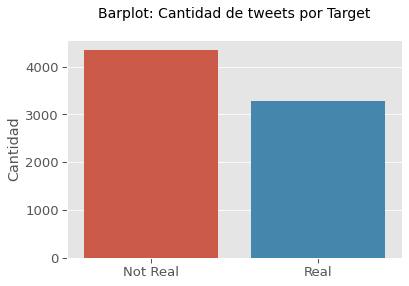

In [8]:
x=train['target'].value_counts()
g=sns.barplot(x.index,x)
g.set_title('Barplot: Cantidad de tweets por Target\n',fontsize=14)
g.set_ylabel('Cantidad')
plt.xticks([0, 1], ['Not Real', 'Real'])
plt.show()


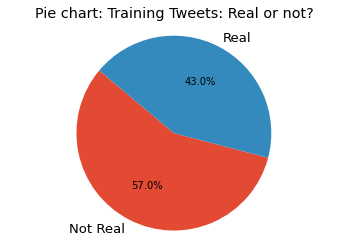

In [9]:
labels='Not Real','Real'
g2=plt.pie(x,labels=labels,autopct='%1.1f%%',startangle=140)
plt.axis('equal')
plt.title('Pie chart: Training Tweets: Real or not?')
plt.show()

In [0]:
train['keyword']=train['keyword'].fillna('no_keyword')
train['location']=train['location'].fillna('no_location')

Analicemos "location" y veamos si tiene sentido mantenerlo en el análisis...

In [11]:
locations=train.location.value_counts(normalize=True)*100
locations

no_location                                      33.3
USA                                               1.4
New York                                          0.9
United States                                     0.7
London                                            0.6
                                         ...         
University of Toronto                             0.0
The Meadow                                        0.0
NJ/NY/NM/NE/ND                                    0.0
Philadelphia, Pennsylvania USA                    0.0
Yewa zone                                         0.0
Name: location, Length: 3342, dtype: float64

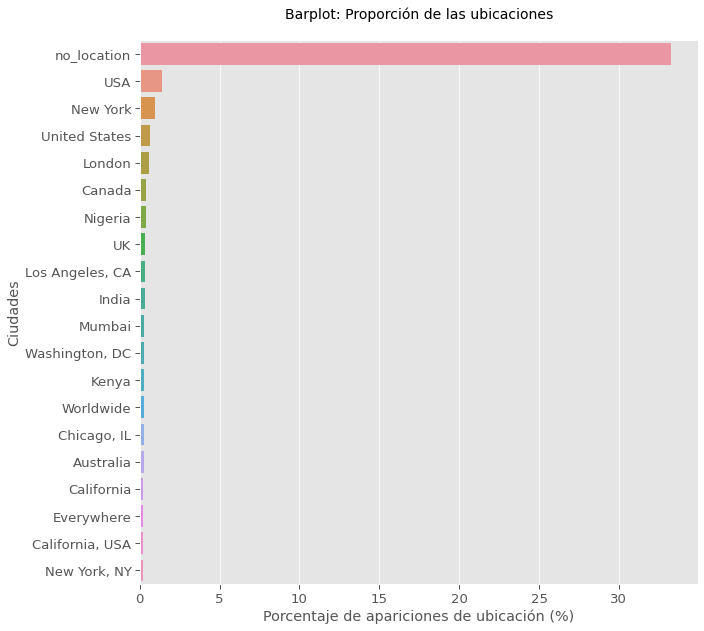

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

x=(100*train['location'].value_counts(normalize=True)).head(20)
g=sns.barplot(x,(x.index))
g.set_title('Barplot: Proporción de las ubicaciones\n',fontsize=14)
g.set_ylabel('Ciudades')
g.set_xlabel('Porcentaje de apariciones de ubicación (%)')

plt.show()

# Cleaning de tweets repetidos

Pasos del cleaning:


1.   En columna 'text', identificar strings repetidos
2.   Para los strings identificados en el punto 1, identificar los que tengan 2 targets distintos
3. Eliminar las filas identificadas en el punto 2
4. Generar un nuevo DF (train_no_duplicates), con una columna que indique cantidad de repeticiones de cada 'text'(con target único)
5. Descartar las repeticiones de 'text' salvo por la primera ocurrencia
6. Eliminar mentions y urls de cada 'text' y asignar los resultados a una nueva columna 'text_clean'
7. Eliminar signos de puntuación y caracteres especiales de cada 'text_clean'
8. Para 'text_clean' repetir los pasos 1-5 dentro del DF train_no_duplicates.




Se busca ver si los textos se repiten o no, y en caso de repetirse si contienen targets distintos.

In [13]:
duplicated=train.groupby(['text']).agg({'target':['count','nunique']}).reset_index()
duplicated.sort_values(by=('target','count'),ascending=False)

text target        
                                                         count nunique
646   11-Year-Old Boy Charged With Manslaughter of T...     10       1
45    #Bestnaijamade: 16yr old PKK suicide bomber wh...      6       1
6131  The Prophet (peace be upon him) said 'Save you...      6       2
3589  He came to a land which was engulfed in tribal...      6       2
4589  Madhya Pradesh Train Derailment: Village Youth...      5       1
...                                                 ...    ...     ...
2507  Bamenda Floods Kill Animals Birds - http://t.c...      1       1
2506  Baltimore City : I-95 NORTH AT MP 54.8 (FORT M...      1       1
2505  Bairstow dropped his buffet ticket there. Deva...      1       1
2504                                            Bad day      1       1
7502  åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...      1       1

[7503 rows x 3 columns]

Se observa que hay tweets que se repiten hasta 10 veces. A su vez, existen tweets a los que se les asignaron 2 targets al mismo tiempo (columna nunique). Esos datos se deben eliminar ya que afectan al set de entrenamiento.

Incorporaremos una columna donde diga cuántas veces se repiten los tweets. 

In [0]:
train_no_duplicates=train
duplicate_texts=train_no_duplicates.loc[:,['text','target']].groupby(['text']).transform('count')
train_no_duplicates['duplicate_text_count']=duplicate_texts


Eliminamos los textos duplicados con tweets contradictorios


In [0]:
contradiction=train_no_duplicates.loc[:,['text','target']].groupby(['text']).transform('nunique')
train_no_duplicates['count_targets']=contradiction
train_no_duplicates=train_no_duplicates[train.count_targets==1]
train_no_duplicates.drop('count_targets',axis=1,inplace=True)

Una vez eliminados los tweets contradictorios, se eliminan los tweets duplicados (salvo la primera ocurrencia)

In [0]:
train_no_duplicates.drop_duplicates(subset ='text', keep = 'first', inplace = True)

In [17]:
print('El DataFrame post cleaning cuenta con {} filas y {} columnas'.format(train_no_duplicates.shape[0],train.shape[1]))

El DataFrame post cleaning cuenta con 7485 filas y 7 columnas


Se eliminan urls y mentions de cada 'text'

In [0]:
def cleanText(inputString):
  text = re.sub(r'http\S+', '', inputString)  
  text2 = re.sub(r'@\S+', '', text)
  text3 = re.sub(r'&\S+', '', text2)
  text4 = re.sub(r'Ã\S+', '', text3)
  text5 = re.sub(r'www\S+','',text4)
  text5 = re.sub(r'www\S+','',text4)
  text6 = re.sub(r'\x89Û\S+','',text4)

  return (text6)
 
train_no_duplicates['text_clean'] = train_no_duplicates['text'].apply(lambda x: cleanText(x))


Se eliminan todas las contracciones, ejemplo I'm --> I am

In [0]:
def decontracted(inputString):

    phrase = re.sub(r"won't", "will not", inputString)
    phrase = re.sub(r"couldn't", "could not", inputString)
    phrase = re.sub(r"can't", "can not", inputString)
    phrase = re.sub(r"don't", "do not", inputString)
    phrase = re.sub(r"doesn't", "does not", inputString)
    phrase = re.sub(r"isn't", "is not", inputString)
    phrase = re.sub(r"mustn't", "must not", inputString)
    phrase = re.sub(r"shouldn't", "was not", inputString)
    phrase = re.sub(r"wasn't", "was not", inputString)
    phrase = re.sub(r"won't", "will not", inputString)


    # general
    phrase = re.sub(r" 's", " \"s", phrase)
    phrase = re.sub(r" 't", " \"t", phrase)
    phrase = re.sub(r" 'd", " \"d", phrase)
    phrase = re.sub(r" 're", " \"re", phrase)
    phrase = re.sub(r" 'll", " \"ll", phrase)
    phrase = re.sub(r" 've", " \"ve", phrase)
    phrase = re.sub(r" 'm", " \"m", phrase)

    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

train_no_duplicates['text_clean'] = train_no_duplicates['text_clean'].apply(lambda x: decontracted(x))

Se eliminan los signos de puntuación


In [0]:

def deletePunctuation(inputString):
  aux=string.punctuation
  special_characters='ÃŒ©‰¥¼ªû'
  #puncts=aux.translate(str.maketrans("#@:/.","     "))
  auxstring=" " * len(aux)
  auxstring2=" " * len(special_characters)
  outputString=inputString.translate(str.maketrans(aux,auxstring))
  outputString=outputString.translate(str.maketrans(special_characters,auxstring2))
  return outputString

train_no_duplicates['text_clean'] = train_no_duplicates['text_clean'].apply(lambda x:deletePunctuation(x))

In [21]:
train_no_duplicates.head(50)

,id,keyword,location,text,target,duplicate_text_count,text_clean
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,1,Our Deeds are the Reason of this earthquake M...
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,1,Forest fire near La Ronge Sask Canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,1,All residents asked to shelter in place are ...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,1,13 000 people receive wildfires evacuation or...
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,1,Just got sent this photo from Ruby Alaska as ...
5,8,no_keyword,no_location,#RockyFire Update => California Hwy. 20 closed...,1,1,RockyFire Update California Hwy 20 closed...
6,10,no_keyword,no_location,#flood #disaster Heavy rain causes flash flood...,1,1,flood disaster Heavy rain causes flash flood...
7,13,no_keyword,no_location,I'm on top of the hill and I can see a fire in...,1,1,I am on top of the hill and I can see a fire i...
8,14,no_keyword,no_location,There's an emergency evacuation happening now ...,1,1,There is an emergency evacuation happening now...
9,15,no_keyword,no_location,I'm afraid that the tornado is coming to our a...,1,1,I am afraid that the tornado is coming to our ...


Se debe repetir el mismo análisis de tweets duplicados

In [22]:
duplicated_clean=train_no_duplicates.groupby(['text_clean']).agg({'target':['count','nunique']}).reset_index()
duplicated_clean=duplicated_clean.sort_values(by=('target','count'),ascending=False)
duplicated_clean

text_clean target        
                                                         count nunique
6271  Watch This Airport Get Swallowed Up By A Sands...     24       1
6497  Wreckage  Conclusively Confirmed  as From MH37...     20       1
3181  Families to sue over Legionnaires  More than 4...     19       1
1607   hot  Funtenna  hijacking computers to send da...     17       2
2758  Christian Attacked by Muslims at the Temple Mo...     15       1
...                                                 ...    ...     ...
2333       Ancient Mayan Tablet Found in Jungle Temple       1       1
2332  An outbreak of Legionnaires  disease in New Yo...      1       1
2331  An outbreak of Legionnaires  disease in New Yo...      1       1
2330  An optical illusion   clouds rolling in over t...      1       1
6939  åÈMGN AFRICAå¨ pin 263789F4 åÈ Correction  Ten...      1       1

[6940 rows x 3 columns]

In [23]:
train_no_duplicates.describe()

,id,target,duplicate_text_count
count,"7,485.0","7,485.0","7,485.0"
mean,"5,440.1",0.4,1.0
std,"3,143.4",0.5,0.2
min,1.0,0.0,1.0
25%,"2,726.0",0.0,1.0
50%,"5,404.0",0.0,1.0
75%,"8,155.0",1.0,1.0
max,"10,873.0",1.0,10.0


Se agrega una columna que especifique cuantos text_clean se repiten

In [24]:
duplicate_texts_clean=train_no_duplicates.loc[:,['text_clean','target']].groupby(['text_clean']).transform('count')
train_no_duplicates['duplicate_text_clean_count']=duplicate_texts_clean
train_no_duplicates['text_clean'][3]

'13 000 people receive  wildfires evacuation orders in California '

Eliminar los que tienen targets contradictorios

In [0]:
contradiction_clean=train_no_duplicates.loc[:,['text_clean','target']].groupby(['text_clean']).transform('nunique')
train_no_duplicates['count_targets']=contradiction_clean
train_no_duplicates=train_no_duplicates[train_no_duplicates.count_targets==1]
train_no_duplicates.drop('count_targets',axis=1,inplace=True)

Elimino rows de duplicados salvo primera ocurrencia

In [0]:
train_no_duplicates.drop_duplicates(subset ='text_clean', keep = 'first', inplace = True)

In [27]:
print('El DataFrame post cleaning cuenta con {} filas y {} columnas'.format(train_no_duplicates.shape[0],train.shape[1]))

El DataFrame post cleaning cuenta con 6889 filas y 7 columnas


# Eliminación de stopwords

In [0]:
def deleteStopwords(inputString):
  inputString= inputString.lower()
  text_tokens = word_tokenize(inputString)
  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]
  filtered_sentence = (" ").join(tokens_without_sw)
  return filtered_sentence

train_no_duplicates['text_clean_no_sw'] = train_no_duplicates['text_clean'].apply(lambda x:deleteStopwords(x))

# Proporción de Target Real/Not Real

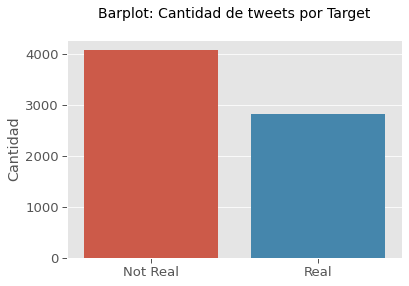

In [29]:
#Cantidad de muestras 

x=train_no_duplicates['target'].value_counts()
g=sns.barplot(x.index,x)
g.set_title('Barplot: Cantidad de tweets por Target\n',fontsize=14)
g.set_ylabel('Cantidad')
plt.xticks([0, 1], ['Not Real', 'Real'])
plt.show()


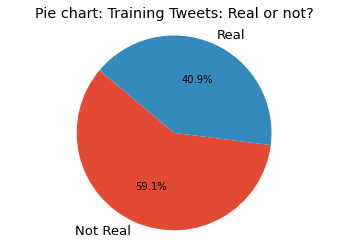

In [30]:
labels='Not Real','Real'
g2=plt.pie(x,labels=labels,autopct='%1.1f%%',startangle=140)
plt.axis('equal')
plt.title('Pie chart: Training Tweets: Real or not?')
plt.show()


Se observa mayor proporción de tweets de clase "Not Real" sobre los de clase "Real". 

Se puede dividir el DF en 2 subsets

In [0]:
train1=train_no_duplicates[train_no_duplicates['target']==1]
train0=train_no_duplicates[train_no_duplicates['target']==0]

# Análisis de Keywords

In [0]:
def percent_real_disaster(x):
    return x.mean()*100 


grouped=train_no_duplicates.groupby(['keyword']).agg({'target':[percent_real_disaster]}).sort_values(by=('target','percent_real_disaster'),ascending=False)
grouped=grouped.reset_index()


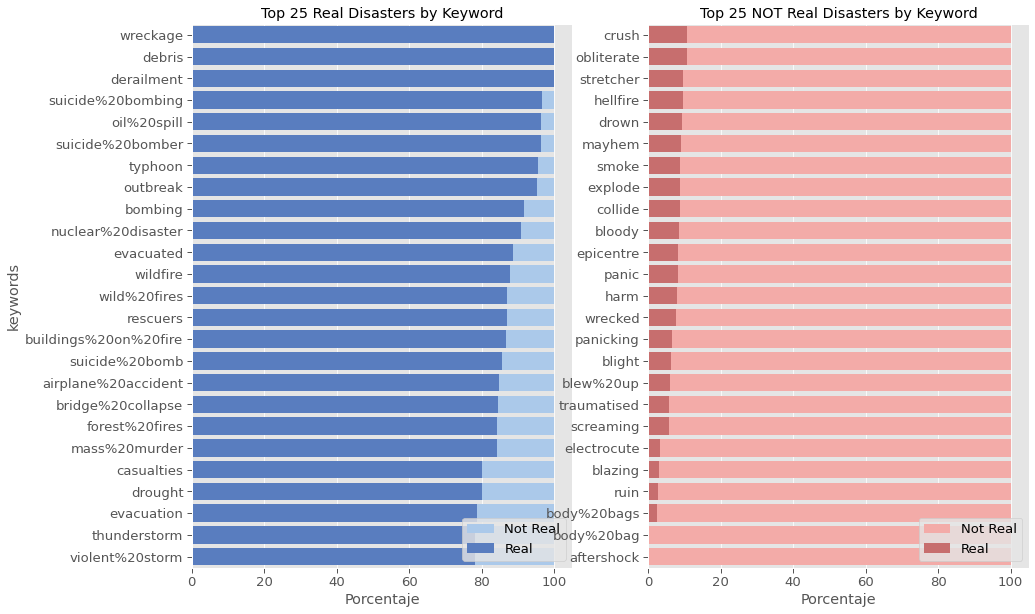

In [33]:
#Plot 
#Ploteo el total de tweets por keyword
f, axes = plt.subplots(1,2, figsize=(15, 10), sharex=True)

#Los keywords con mayor proporción de tweets Reales
sns.set_color_codes("pastel")
g1=sns.barplot(ax=axes[0],x=100,y='keyword',data=grouped.head(25),label='Not Real', color="b")
sns.set_color_codes("muted")
sns.barplot(ax=axes[0],x=('target','percent_real_disaster'),y='keyword',data=grouped.head(25), label='Real',color="b")
g1.set_ylabel('keywords')
g1.set_xlabel('Porcentaje')
g1.set_title('Top 25 Real Disasters by Keyword')

#los peores 10
sns.set_color_codes("pastel")
g2=sns.barplot(ax=axes[1],x=100,y='keyword',data=grouped.tail(25), label='Not Real',color="r")
sns.set_color_codes("muted")
sns.barplot(ax=axes[1],x=('target','percent_real_disaster'),y='keyword',data=grouped.tail(25),label='Real', color="r")
g2.set_ylabel('')
g2.set_xlabel('Porcentaje')
g2.set_title('Top 25 NOT Real Disasters by Keyword')

# Legend
g1.legend(ncol=1, loc="lower right", frameon=True)
g2.legend(ncol=1, loc="lower right", frameon=True)

plt.show()

En la figura se la izquiera se ilustran 25 keywords con porcentajes de Target "Real" mayores al 75%. Se observan keywords referentes a desastres naturales (*drought, forest fire, violent storm)* o edilicios (*bridge collapse, buildings on fire*). También se encuentran tragedias mortales (*mass murder, airplane accident, nuclear disaster, suicide bombing*). Otros keywords incluyen lenguaje de noticias (*casualties, evacuated, rescuers*). 

Por otro lado, en la figura de la derecha, se observan los 25 keywords con menores porcentajes de veracidad. En su mayoría se trata de palabras que servirían para describir tragedias pero que a su vez pueden usarse en muchos otros contextos. Un ejemplo de esto es el keyword "body bag", con un porcentaje de targets Reales menor al 5%. El término por si solo sonaría alarmante, pero veamos las acepciones de la palabra:

1.   Bolsa para guardar cadáveres
2.   Una clase de cartera/mochila
3.   Según *Urban Dictionary*, "To boddybag an oponent" es asegurar la victoria sobre el oponente (algo así como "kick ass"), slang muy utilizado en las batallas de rap.
4.   Otra acepción de *Urban Dictionary*, "Bodybagging" es robarle un chiste a otro comediante y hacerlo pasar como propio. 

Se observa también mayor cantidad de verbos y adjetivos que en el otro target.




# Análisis de características de tweets

In [0]:
def url_count(a):
  a=a.split()
  i=0
  count=0
  while i<len(a):
    if 'http:' in a[i] or 'www.' in a[i]:
      count=count+1
    i=i+1
  return count 

In [0]:
def mention_count(a):
  a=a.split()
  i=0
  count=0
  while i<len(a):
    
    if '@' in a[i]:
      count=count+1
    i=i+1
  return count 

In [0]:
def hashtag_count(a):
  a=a.split()
  i=0
  count=0
  while i<len(a):
    
    if '#' in a[i]:
      count=count+1
    i=i+1
  return count    

In [0]:
def numbers_count(inputString):
  count=0
  i=0
  inputString=inputString.split()
  while i < len(inputString):
    if inputString[i].isdigit() == True:
      count=count+1
    i=i+1
  return count

In [0]:
train_no_duplicates['url_count'] = train_no_duplicates['text'].apply(lambda x: url_count(x))
train_no_duplicates['hashtag_count'] = train_no_duplicates['text'].apply(lambda x: hashtag_count(x))
train_no_duplicates['mention_count'] = train_no_duplicates['text'].apply(lambda x: mention_count(x))
train_no_duplicates['digits_count'] = train_no_duplicates['text_clean'].apply(lambda x: numbers_count(x))
train_no_duplicates['characters_count'] = train_no_duplicates['text'].apply(lambda x: len(x))
train_no_duplicates['characters_count_clean'] = train_no_duplicates['text_clean'].apply(lambda x: len(x))
train_no_duplicates['characters_count_clean_sw'] = train_no_duplicates['text_clean_no_sw'].apply(lambda x: len(x))
train_no_duplicates['word_count'] = train_no_duplicates['text'].apply(lambda x: len(x.split()))
train_no_duplicates['word_count_clean'] = train_no_duplicates['text_clean'].apply(lambda x: len(x.split()))
train_no_duplicates['word_count_clean_sw'] = train_no_duplicates['text_clean_no_sw'].apply(lambda x: len(x.split()))
train_no_duplicates['avg_word_len']= train_no_duplicates['characters_count']/ train_no_duplicates['word_count']
train_no_duplicates['avg_word_len_clean_sw']= train_no_duplicates['characters_count_clean_sw']/ train_no_duplicates['word_count_clean_sw']

In [0]:
cols_stats= ['url_count','hashtag_count','mention_count','digits_count','characters_count','characters_count_clean_sw',\
             'word_count','word_count_clean_sw','avg_word_len','avg_word_len_clean_sw','target']

In [42]:
train_no_duplicates[cols_stats].groupby('target').agg(['mean','std','skew'])

url_count  ... avg_word_len_clean_sw
                       mean  ...                  skew
target                       ...                      
0                       0.4  ...                   0.7
1                       0.7  ...                   0.4

[2 rows x 30 columns]

<function matplotlib.pyplot.show>

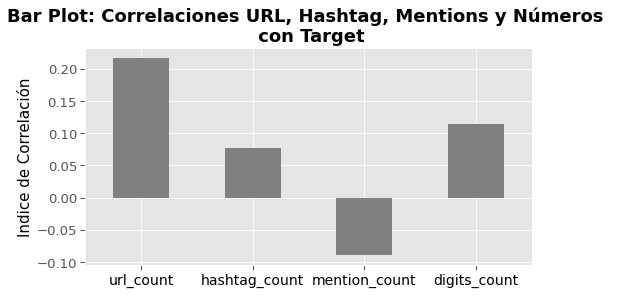

In [43]:
#Correlacionamos con url, hashtag, mention y digits
corr_cols=['target','url_count','hashtag_count','mention_count','digits_count']
(train_no_duplicates.loc[:,corr_cols].corr())['target'][1:].plot(kind='bar', color='grey', figsize=(8,4))
plt.title('Bar Plot: Correlaciones URL, Hashtag, Mentions y Números \n con Target',fontweight='bold', fontsize=18)
plt.ylabel('Indice de Correlación', fontsize=15, color='black')
plt.xticks(fontsize=14, rotation='horizontal', color='black')
plt.show

In [44]:
train_no_duplicates[['url_count', 'hashtag_count']].corr()

,url_count,hashtag_count
url_count,1.0,0.2
hashtag_count,0.2,1.0


In [45]:
train_no_duplicates[train_no_duplicates.loc[:,'digits_count']>0]['target'].mean()

0.5329712955779674

In [46]:
!pip install ptitprince

     |████████████████████████████████| 61kB 2.7MB/s 
  Created wheel for ptitprince: filename=ptitprince-0.2.3-cp36-none-any.whl size=8445 sha256=366b05096df944c85b86239bfe5c52b1b83319a2469db654a66ab6bed220a971
  Stored in directory: /root/.cache/pip/wheels/0a/f8/51/69b54ac713d656ee1a792a3cd5f33deb742156183882b01c10
Successfully built ptitprince


PLOTEAMOS LA DISTRIBUCION DE LA CANTIDAD DE CARACTERES

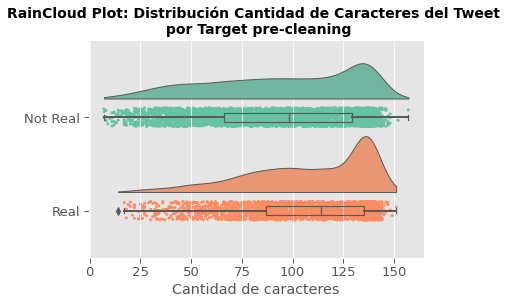

In [47]:
import ptitprince as pt
ax=pt.RainCloud(x='target',y='characters_count',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución Cantidad de Caracteres del Tweet \n por Target pre-cleaning',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de caracteres')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()

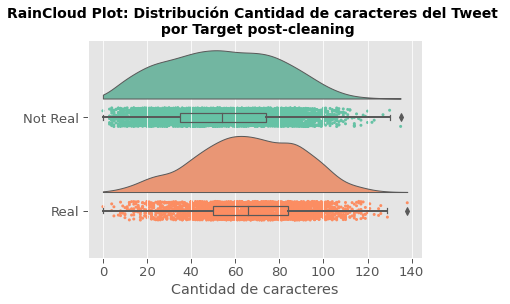

In [48]:
import ptitprince as pt
ax=pt.RainCloud(x='target',y='characters_count_clean_sw',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución Cantidad de caracteres del Tweet \n por Target post-cleaning',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de caracteres')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()

PLOTEAMOS LA DISTRIBUCION DE LA CANTIDAD DE PALABRAS

Text(0.5, 1.0, 'Countplot: Distribuión de Cantidad de Palabras \n por Target (pre-cleaning)')

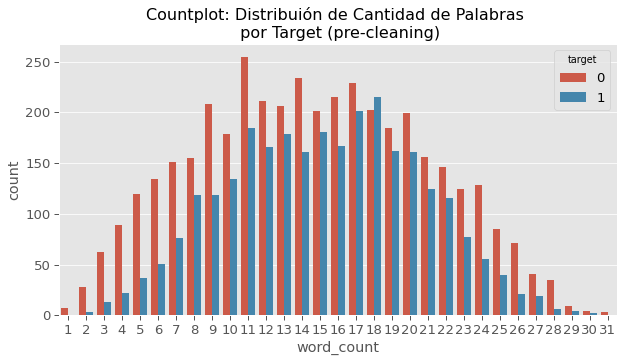

In [49]:
#Comparamos las distribuciones de Cantidad de Palabras pre-cleaning. 

plt.figure(figsize=(10,5))
sns.countplot(x='word_count',data=train_no_duplicates, hue='target')
plt.title('Countplot: Distribuión de Cantidad de Palabras \n por Target (pre-cleaning)', fontsize=16)



Text(0.5, 1.0, 'Countplot: Distribuión de Cantidad de Palabras \n por Target (post-cleaning)')

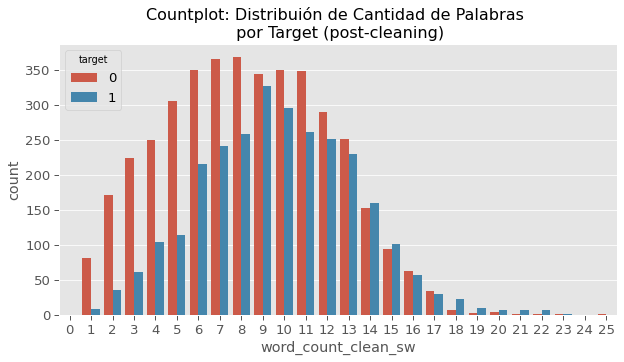

In [50]:
#seaborn countplots
#Comparamos las distribuciones de Cantidad de Palabras pre-cleaning. 

plt.figure(figsize=(10,5))
sns.countplot(x='word_count_clean_sw',data=train_no_duplicates, hue='target')
plt.title('Countplot: Distribuión de Cantidad de Palabras \n por Target (post-cleaning)', fontsize=16)



PLOTEAMOS LA DISTRIBUCION DE CANTIDAD DE CARACTERES PROMEDIO DE LAS PALABRAS

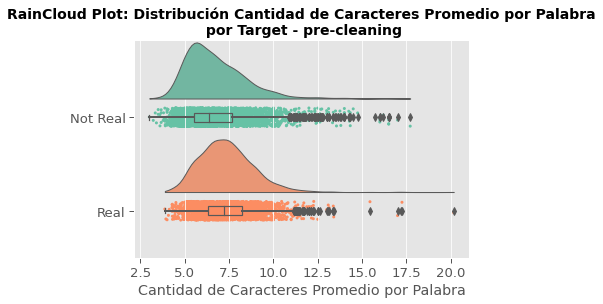

In [51]:
ax=pt.RainCloud(x='target',y='avg_word_len',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución Cantidad de Caracteres Promedio por Palabra\n por Target - pre-cleaning',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de Caracteres Promedio por Palabra')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()

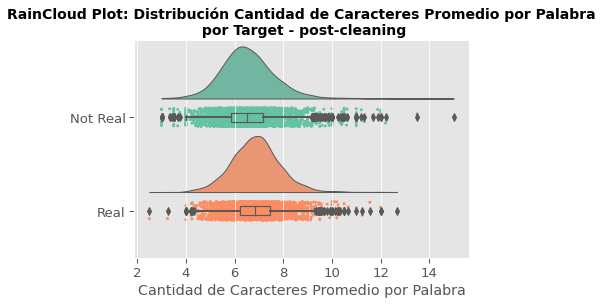

In [52]:
ax=pt.RainCloud(x='target',y='avg_word_len_clean_sw',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución Cantidad de Caracteres Promedio por Palabra\n por Target - post-cleaning',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de Caracteres Promedio por Palabra')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()

In [53]:
#Asimetrias para avg_word_len
print(train_no_duplicates[train_no_duplicates.loc[:,'target']==0]['avg_word_len'].skew())
print(train_no_duplicates[train_no_duplicates.loc[:,'target']==1]['avg_word_len'].skew())

1.403000246191955
1.0159676672467375


In [54]:
#Asimetría para av_word_len_clen_sw
print(train_no_duplicates[train_no_duplicates.loc[:,'target']==0]['avg_word_len_clean_sw'].skew())
print(train_no_duplicates[train_no_duplicates.loc[:,'target']==1]['avg_word_len_clean_sw'].skew())

0.6916816119009352
0.36777391143636945


URL COUNT

In [55]:
#Veamos la correlación entre estas dos variables. 
train_no_duplicates[['target','url_count']].corr()

,target,url_count
target,1.0,0.2
url_count,0.2,1.0


Text(0.5, 1.0, 'Countplot: Distribuión de Cantidad de URLs \n por Target')

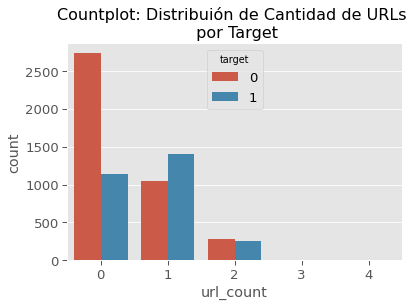

In [56]:
#URl count
sns.countplot(x='url_count',data=train_no_duplicates, hue='target')
plt.title('Countplot: Distribuión de Cantidad de URLs \n por Target', fontsize=16)


In [57]:
#el 55.51% de los que tienen url son target==1
train_no_duplicates[train_no_duplicates.loc[:,'url_count']>0]['target'].mean()

0.5551495016611295

In [58]:
#El 70.45% de los que no tienen url son target==0
1-train_no_duplicates[train_no_duplicates.loc[:,'url_count']==0]['target'].mean()

0.7045630317092034

HASHTAG COUNT

Text(0.5, 1.0, 'Countplot: Distribuión de Cantidad de Hashtag \n por Target')

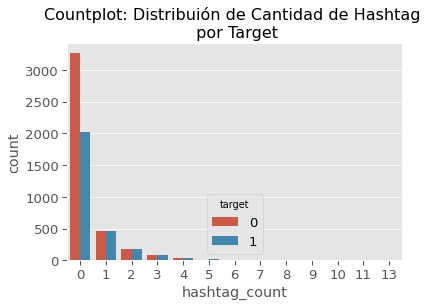

In [59]:
#Hashtag count
sns.countplot(x='hashtag_count',data=train_no_duplicates, hue='target')
plt.title('Countplot: Distribuión de Cantidad de Hashtag \n por Target', fontsize=16)

MENTION COUNT

Text(0.5, 1.0, 'Countplot: Distribuión de Cantidad de Mentions \n por Target')

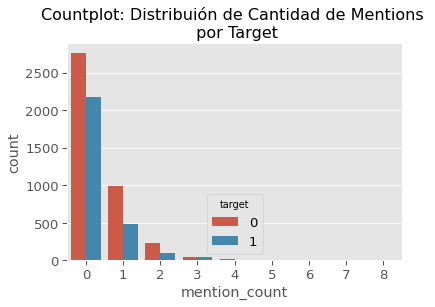

In [60]:
#Mentions count
sns.countplot(x='mention_count',data=train_no_duplicates, hue='target')
plt.title('Countplot: Distribuión de Cantidad de Mentions \n por Target', fontsize=16)

DIGITS COUNT

Text(0.5, 1.0, 'Countplot: Distribuión de Cantidad de Digits \n por Target')

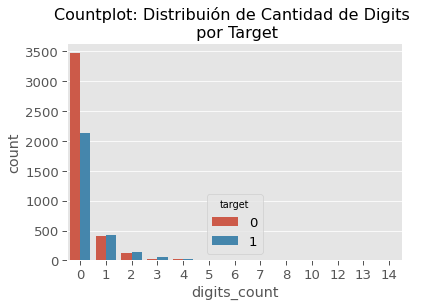

In [61]:
#digit count
sns.countplot(x='digits_count',data=train_no_duplicates, hue='target')
plt.title('Countplot: Distribuión de Cantidad de Digits \n por Target', fontsize=16)

In [62]:
train_no_duplicates[train_no_duplicates.loc[:,'digits_count']>0]['target'].mean()

0.5329712955779674

In [63]:
1-train_no_duplicates[train_no_duplicates.loc[:,'url_count']==0]['target'].mean()

0.7045630317092034

In [64]:
#Value Counts de digits_count
train_no_duplicates.digits_count.value_counts()

0     5600
1      831
2      263
3       83
4       56
6       14
5       14
7       11
14      11
8        3
10       1
13       1
12       1
Name: digits_count, dtype: int64

# Análisis de clase de palabras

Se requiere uso de librería TweetTokenizer para poder interpretar correctamente la clase de cada palabra, dado que no se puede realizar sacando las palabras de su contexto. Hay que hacerlo primero obteniendo los tags para cada fila, luego unificarlos. Los tags provienen del tagset Penn Treebank Tokenization. Hemos agrupado las sub-clases en clases. 


In [0]:
clases_y_subclases = {'noun': [('NN','singular comon noun'), 
                             ('NNP','singular poper noun'),
                             ('NNS', 'plural comon noun'),
                             ('NNPS', 'plural proper noun')],
                      'verb':  [('VB', 'base form verb'),
                              ('VBD', 'past tense verb'),
                              ('VBG','verb, present participle or gerund'),
                              ('VBN', 'verb, past participle'),
                              ('VBP','verb, present tense, not 3rd person singular'), 
                              ('VBZ','verb, present tense, 3rd person singular'),
                              ('MD','modal auxiliary')],
                      'adjetives': [('JJ','adjective or numeral, ordinal'),
                                    ('JJR','adjective, comparative'),
                                    ('JJS','adjective, superlative')],
                      'pronouns': [('PRP','pronoun, personal'),
                                   ('PRP$','pronoun, possessive'),
                                   ('WP','WH-pronoun'),
                                   ('WP$','WH-pronoun, possessive')],
                      'determiners': [('PDT','pre-determiner'),
                                      ('DT','determiner'),
                                      ('WDT','WH-determiner')],
                      'adverbs': [('RB','adverb'),
                                  ('RBR','adverb, comparative'),
                                  ('RBS','adverb, superlative'),
                                  ('RP','particle'),
                                  ('EX','existential there')],
                      'prepositions': [('IN','preposition or conjunction, subordinating'),
                                       ('TO','to as preposition or infinitive marker')],
                      'conjuctions': [('CC','conjunction, coordinating')],
                      'numerals_cardinals': [('CD','numeral, cardinal')],
                      'foreing_words': [('FW','foreing word')],
                      'quotes': [("''",'quotes')],
                      'interjections': [('UH','interjection')],
                      '$': [('$','dolar')],
                      'symbols': [('SYM','symbol')]
}

In [66]:
#Obtenemos el token de cada texto. 
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
train_no_duplicates['tokenized_text']=train_no_duplicates['text_clean'].apply(lambda x: x.lower()).apply(tt.tokenize) 
train_no_duplicates['tokenized_text']

0       [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ronge, sask, canada]
2       [all, residents, asked, to, shelter, in, place...
3       [13, 000, people, receive, wildfires, evacuati...
4       [just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7602    [a, siren, just, went, off, and, it, wasn, not...
7603    [officials, say, a, quarantine, is, in, place,...
7604    [worldnews, fallen, powerlines, on, g, link, t...
7605    [on, the, flip, side, i, am, at, walmart, and,...
7606    [suicide, bomber, kills, 15, in, saudi, securi...
Name: tokenized_text, Length: 6889, dtype: object

In [67]:
#Para cada token obtenemos el tag (clase de palabra)
train_no_duplicates['pos_tagged_text'] = train_no_duplicates['tokenized_text'].apply(nltk.Text).apply(nltk.pos_tag) #Este paso me transforma la lista en 
#un texto entre paréntesis (que no sé qué es) y luego me arma una lista de tuplas (k,v) con la palabra y la clase de palabra. 
train_no_duplicates['pos_tagged_text'] 

0       [(our, PRP$), (deeds, NNS), (are, VBP), (the, ...
1       [(forest, JJS), (fire, NN), (near, IN), (la, J...
2       [(all, DT), (residents, NNS), (asked, VBD), (t...
3       [(13, CD), (000, CD), (people, NNS), (receive,...
4       [(just, RB), (got, VBN), (sent, VBD), (this, D...
                              ...                        
7602    [(a, DT), (siren, NN), (just, RB), (went, VBD)...
7603    [(officials, NNS), (say, VBP), (a, DT), (quara...
7604    [(worldnews, NNS), (fallen, VBN), (powerlines,...
7605    [(on, IN), (the, DT), (flip, JJ), (side, NN), ...
7606    [(suicide, JJ), (bomber, NN), (kills, NNS), (1...
Name: pos_tagged_text, Length: 6889, dtype: object

In [68]:
#En cada fila contamos la frecuencia de las clases de palabras
from collections import Counter
train_no_duplicates['pos_tagg_counts']=train_no_duplicates['pos_tagged_text'].apply(lambda x: Counter(tag for word,tag in x))
train_no_duplicates['pos_tagg_counts']

0       {'PRP$': 1, 'NNS': 1, 'VBP': 1, 'DT': 3, 'NN':...
1                   {'JJS': 1, 'NN': 4, 'IN': 1, 'JJ': 1}
2       {'DT': 2, 'NNS': 3, 'VBD': 1, 'TO': 1, 'VB': 1...
3          {'CD': 2, 'NNS': 3, 'JJ': 1, 'NN': 2, 'IN': 1}
4       {'RB': 1, 'VBN': 1, 'VBD': 1, 'DT': 2, 'NN': 4...
                              ...                        
7602    {'DT': 2, 'NN': 4, 'RB': 3, 'VBD': 1, 'CC': 1,...
7603    {'NNS': 2, 'VBP': 1, 'DT': 3, 'NN': 6, 'VBZ': ...
7604    {'NNS': 5, 'VBN': 2, 'IN': 1, 'NN': 4, 'JJ': 1...
7605    {'IN': 4, 'DT': 2, 'JJ': 2, 'NN': 5, 'VBP': 2,...
7606       {'JJ': 2, 'NN': 8, 'NNS': 2, 'CD': 1, 'IN': 2}
Name: pos_tagg_counts, Length: 6889, dtype: object

In [69]:
#Creamos un dataframe con la misma cantidad de filas que el dataframe con el que venimos trabajando. 
#Las columnas serán todas las clases de palabras existentes en la librería nltk que estén dentro de nuestras frecuencias. 
data = train_no_duplicates['pos_tagg_counts']
word_classes_df = pd.DataFrame.from_records(data, columns = data.sum().keys())
len(word_classes_df)

6889

In [70]:
#Dicho dataframe posee por fila el dato de la frecuencia para cada clase. 
word_classes_df.fillna(0,inplace=True)
word_classes_df

,PRP$,NNS,VBP,DT,NN,IN,MD,VB,JJ,PRP,JJS,VBD,TO,VBG,VBN,CC,CD,RB,EX,VBZ,WP,RP,JJR,WRB,$,WDT,NNP,RBR,RBS,PDT,SYM,FW,UH,'',WP$
0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3.0,2.0,2.0,4.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,2.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6885,0.0,2.0,1.0,3.0,6.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6886,0.0,5.0,1.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6887,0.0,1.0,2.0,2.0,5.0,4.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
#Creamos una lista con 6889 elementos, todos integeres desde el 0 al 6888 inclusive, para poder usar como indice de la tabla train_no_duplicates
def create_integers_ascending_list(number_elements): 
  lista=[]
  i=0
  number=0
  while i<number_elements: 
    lista.append(number)
    number=number+1
    i=i+1
  return lista

int_list=create_integers_ascending_list(6889)
len(int_list)

6889

In [0]:
#incorporamos la lista de integers al dataframe
train_no_duplicates['index']=int_list

In [73]:
#Corroboramos que no haya generado nulls. 
train_no_duplicates['index'].isnull().value_counts()

False    6889
Name: index, dtype: int64

In [0]:
#seteamos un nuevo índice en train_no_duplicates para poder hacer el concat. 
train_no_duplicates.set_index('index', inplace=True)

In [75]:
#Obtenemos el nuevo dataframe
train_no_duplicates_merge_word_classes=pd.concat([train_no_duplicates,word_classes_df],axis=1)
train_no_duplicates_merge_word_classes.shape

(6889, 59)

In [0]:
correlation = (train_no_duplicates_merge_word_classes.corr())['target'][16:]

In [77]:
#Variables que tienen correlación mayor a 0.1
correlation[correlation.values>=0.1]

NNS                    0.2
NN                     0.1
IN                     0.1
CD                     0.1
Name: target, dtype: float64

In [78]:
#Varibales que tienen correlación menor a -0.1
correlation[correlation.values<=-0.1]

PRP$                   -0.1
VBP                    -0.1
VB                     -0.1
PRP                    -0.2
RB                     -0.1
Name: target, dtype: float64

<function matplotlib.pyplot.show>

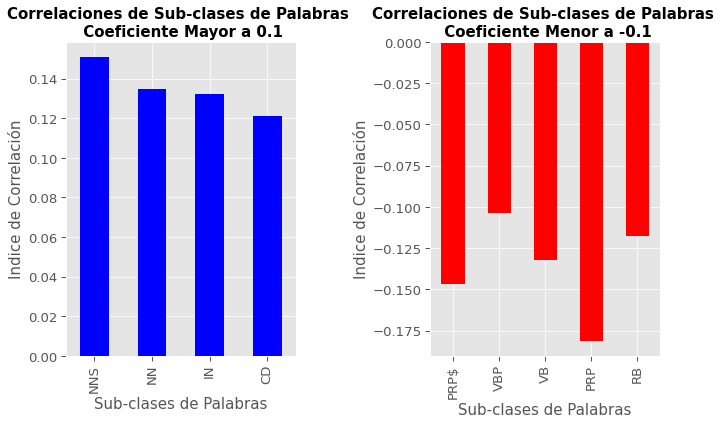

In [79]:
plt.subplot(1, 2, 1)

#Variables que tienen correlación mayor a 0.1
correlation[correlation.values>=0.1].plot(kind='bar', color='blue', figsize=(10,6))
plt.title('Correlaciones de Sub-clases de Palabras \n Coeficiente Mayor a 0.1',fontweight='bold', fontsize=15)
plt.ylabel('Indice de Correlación', fontsize=15)
plt.xlabel('Sub-clases de Palabras', fontsize=15)

plt.subplot(1, 2, 2)

#Varibales que tienen correlación menor a -0.1
correlation[correlation.values<=-0.1].plot(kind='bar', color='red', figsize=(10,6))
plt.title('Correlaciones de Sub-clases de Palabras \n Coeficiente Menor a -0.1',fontweight='bold', fontsize=15)
plt.ylabel('Indice de Correlación', fontsize=15)
plt.xlabel('Sub-clases de Palabras', fontsize=15)

plt.tight_layout()
plt.show

In [80]:
#Armo una lista con todos los nombres de las clases de palabras. 
agg_cols=train_no_duplicates_merge_word_classes.columns[24:].tolist()
agg_cols

['PRP$',
 'NNS',
 'VBP',
 'DT',
 'NN',
 'IN',
 'MD',
 'VB',
 'JJ',
 'PRP',
 'JJS',
 'VBD',
 'TO',
 'VBG',
 'VBN',
 'CC',
 'CD',
 'RB',
 'EX',
 'VBZ',
 'WP',
 'RP',
 'JJR',
 'WRB',
 '$',
 'WDT',
 'NNP',
 'RBR',
 'RBS',
 'PDT',
 'SYM',
 'FW',
 'UH',
 "''",
 'WP$']

In [0]:
#Construyo la lista de nombres de columnas para poder hacer la agregación sólo sobre ellas. 
agg_cols.append('target')

In [82]:
agg_cols

['PRP$',
 'NNS',
 'VBP',
 'DT',
 'NN',
 'IN',
 'MD',
 'VB',
 'JJ',
 'PRP',
 'JJS',
 'VBD',
 'TO',
 'VBG',
 'VBN',
 'CC',
 'CD',
 'RB',
 'EX',
 'VBZ',
 'WP',
 'RP',
 'JJR',
 'WRB',
 '$',
 'WDT',
 'NNP',
 'RBR',
 'RBS',
 'PDT',
 'SYM',
 'FW',
 'UH',
 "''",
 'WP$',
 'target']

In [83]:
#Hacemos el agrupamiento sobre algunas columnas by 'target' con algunas medidas estadísticas
tags_stats_by_target=train_no_duplicates_merge_word_classes[agg_cols].groupby('target').mean()
tags_stats_by_target

,PRP$,NNS,VBP,DT,NN,IN,MD,VB,JJ,PRP,JJS,VBD,TO,VBG,VBN,CC,CD,RB,EX,VBZ,WP,RP,JJR,WRB,$,WDT,NNP,RBR,RBS,PDT,SYM,FW,UH,'',WP$
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.3,0.8,0.6,1.0,3.7,1.3,0.2,0.6,1.3,0.6,0.0,0.4,0.3,0.4,0.3,0.3,0.3,0.7,0.0,0.5,0.1,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.1,1.1,0.4,0.9,4.3,1.6,0.1,0.4,1.4,0.3,0.1,0.5,0.2,0.4,0.4,0.2,0.6,0.5,0.0,0.4,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#Eliminamos las que tienen valores bajos, es decir, por columna la suma sea inferior a 0.07
barplot=tags_stats_by_target.loc[:,tags_stats_by_target.sum()>=0.07]

In [85]:
print(len(barplot.iloc[1,:].values))
print(len(barplot.iloc[0,:].values))
print(len(list(barplot.iloc[0,:].index)))

23
23
23


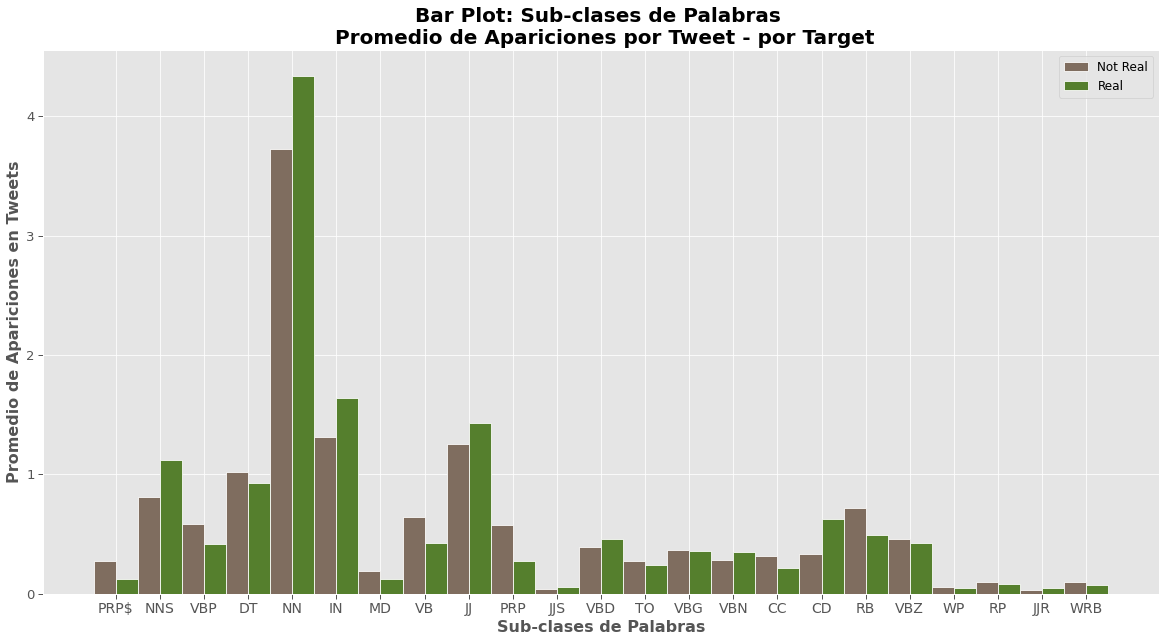

In [86]:
# set width of bar
barWidth = 0.50
 
# set height of bar
target_0_subclases = barplot.iloc[0,:].values
target_1_subclases = barplot.iloc[1,:].values
xticks_word_tags=list(barplot.iloc[0,:].index)

# Set position of bar on X axis
r1 = np.arange(len(target_0_subclases))
r2 = [x + barWidth for x in r1]
 
# Make the plot
fig=plt.figure(figsize=(20,10))
plt.bar(r1, target_0_subclases, color='#7f6d5f', width=barWidth, edgecolor='white', label='Not Real')
plt.bar(r2, target_1_subclases, color='#557f2d', width=barWidth, edgecolor='white', label='Real')
 
# Labels and titles
plt.xlabel('Sub-clases de Palabras', fontweight='bold',fontsize=16)
plt.ylabel('Promedio de Apariciones en Tweets', fontweight='bold',fontsize=16)
plt.xticks([r + 0.25 for r in range(len(target_0_subclases))],xticks_word_tags,rotation='horizontal',fontsize=14)
plt.title('Bar Plot: Sub-clases de Palabras \n Promedio de Apariciones por Tweet - por Target', fontweight='bold',fontsize=20)

# Create legend & Show graphic
plt.legend(fontsize=12)
plt.show()


In [0]:
#Vamos a volver a utilizar este dataframe para agrupar las sub-clases en clases y poder realizar el análisis por clase. 
word_classes_aggregation = train_no_duplicates_merge_word_classes[agg_cols]
word_classes_aggregation = word_classes_aggregation.reindex(sorted(word_classes_aggregation.columns),axis=1)


In [88]:
#Vemos cuales son todas las subclases. 
print(word_classes_aggregation.columns[:-1])
print(len(word_classes_aggregation.columns[:-1]))

Index(['$', '''', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD',
       'NN', 'NNP', 'NNS', 'PDT', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP',
       'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
       'WP$', 'WRB'],
      dtype='object')
35


In [0]:
#Acá estamos agregando las 35 sub-clases en 14 clases. 
word_classes_aggregation['nouns']=word_classes_aggregation['NN']+word_classes_aggregation['NNP']+word_classes_aggregation['NNS']
word_classes_aggregation['verbs']=word_classes_aggregation['VB']+word_classes_aggregation['VBD']+word_classes_aggregation['VBG']+\
                                  word_classes_aggregation['VBN']+word_classes_aggregation['VBP']+word_classes_aggregation['VBZ']+\
                                  word_classes_aggregation['MD']
word_classes_aggregation['adjectives']=word_classes_aggregation['JJ']+word_classes_aggregation['JJR']+word_classes_aggregation['JJS']
word_classes_aggregation['pronouns']=word_classes_aggregation['PRP']+word_classes_aggregation['PRP$']+word_classes_aggregation['WP']+word_classes_aggregation['WP$']
word_classes_aggregation['determiners']=word_classes_aggregation['PDT']+word_classes_aggregation['DT']+word_classes_aggregation['WDT']
word_classes_aggregation['adverbs']=word_classes_aggregation['RB']+word_classes_aggregation['RBR']+word_classes_aggregation['RBS']+\
                                            word_classes_aggregation['RP']+word_classes_aggregation['WRB']+word_classes_aggregation['EX']
word_classes_aggregation['prepositions']=word_classes_aggregation['IN']+word_classes_aggregation['TO']
word_classes_aggregation['conjuctions']=word_classes_aggregation['CC']
word_classes_aggregation['numerals_cardinals']=word_classes_aggregation['CD']
word_classes_aggregation['foreing_words']=word_classes_aggregation['FW']
word_classes_aggregation['quotes']=word_classes_aggregation["''"]
word_classes_aggregation['$']=word_classes_aggregation['$']
word_classes_aggregation['interjections']=word_classes_aggregation['UH']
word_classes_aggregation['symbols']=word_classes_aggregation['SYM']

In [90]:
word_classes=word_classes_aggregation[['nouns','verbs','adjectives','pronouns','determiners','adverbs','prepositions','conjuctions','numerals_cardinals','interjections',\
                                       'foreing_words','quotes','$','symbols','target']]
word_classes

,nouns,verbs,adjectives,pronouns,determiners,adverbs,prepositions,conjuctions,numerals_cardinals,interjections,foreing_words,quotes,$,symbols,target
0,3.0,3.0,1.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,4.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,7.0,7.0,1.0,0.0,2.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1
4,5.0,3.0,1.0,0.0,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,4.0,2.0,0.0,1.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6885,8.0,3.0,1.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6886,9.0,4.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
6887,6.0,5.0,2.0,0.0,2.0,4.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [0]:
word_classes_by_target=word_classes.groupby('target').agg(['sum','mean','std','min','max','count'])

In [92]:
word_classes_by_target_mean=word_classes.groupby('target').mean()
word_classes_by_target_mean=word_classes_by_target_mean.loc[:,word_classes_by_target_mean.sum()>0.05].round(2)
word_classes_by_target_mean

,nouns,verbs,adjectives,pronouns,determiners,adverbs,prepositions,conjuctions,numerals_cardinals
target,,,,,,,,,
0,4.5,2.9,1.3,0.9,1.1,0.9,1.6,0.3,0.3
1,5.5,2.5,1.5,0.4,1.0,0.7,1.9,0.2,0.6


In [93]:
list(word_classes_by_target_mean.columns)

['nouns',
 'verbs',
 'adjectives',
 'pronouns',
 'determiners',
 'adverbs',
 'prepositions',
 'conjuctions',
 'numerals_cardinals']

In [0]:
def f(df):

  i=0
  lista0=[]
  lista1=[]
  while i<len(df.iloc[0,:]): 
    serie_0=df.iloc[0,:]
    serie_1=df.iloc[1,:]
    element_0=df.iloc[0,i]
    element_1=df.iloc[1,i]
    serie0i=serie_0/element_0
    serie1i=serie_1/element_1
    lista0.append(list(serie0i))
    lista1.append(list(serie1i))
    i=i+1
  return lista0,lista1

a,b = f(word_classes_by_target_mean)

In [95]:
a[0]

[1.0,
 0.6387665198237885,
 0.29074889867841414,
 0.19823788546255508,
 0.23348017621145375,
 0.2092511013215859,
 0.3502202643171806,
 0.06828193832599119,
 0.07268722466960353]

In [0]:
dataframe_relta=pd.DataFrame({'nouns': a[0],
                              'verbs': a[1],
                              'adjetives':a[2],
                              'pronouns': a[3],
                              'determiners':a[4],
                              'adverbs': a[5],
                              'prepositions': a[6],
                              'conjuctions': a[7],
                              'numerals_cardinals': a[8]})

In [97]:
dataframe_relta['index']=list(word_classes_by_target_mean.columns)
dataframe_relta.set_index('index')

,nouns,verbs,adjetives,pronouns,determiners,adverbs,prepositions,conjuctions,numerals_cardinals
index,,,,,,,,,
nouns,1.0,1.6,3.4,5.0,4.3,4.8,2.9,14.6,13.8
verbs,0.6,1.0,2.2,3.2,2.7,3.1,1.8,9.4,8.8
adjectives,0.3,0.5,1.0,1.5,1.2,1.4,0.8,4.3,4.0
pronouns,0.2,0.3,0.7,1.0,0.8,0.9,0.6,2.9,2.7
determiners,0.2,0.4,0.8,1.2,1.0,1.1,0.7,3.4,3.2
adverbs,0.2,0.3,0.7,1.1,0.9,1.0,0.6,3.1,2.9
prepositions,0.4,0.5,1.2,1.8,1.5,1.7,1.0,5.1,4.8
conjuctions,0.1,0.1,0.2,0.3,0.3,0.3,0.2,1.0,0.9
numerals_cardinals,0.1,0.1,0.2,0.4,0.3,0.3,0.2,1.1,1.0


In [0]:
dataframe_relat_target_0=dataframe_relta

In [0]:
dataframe_relat_target_1=pd.DataFrame({'nouns': b[0],
                              'verbs': b[1],
                              'adjetives':b[2],
                              'pronouns': b[3],
                              'determiners':b[4],
                              'adverbs': b[5],
                              'prepositions': b[6],
                              'conjuctions': b[7],
                              'numerals_cardinals': b[8]})

In [0]:
dataframe_relat_target_0.set_index('index',inplace=True)

In [101]:
dataframe_relat_target_0

,nouns,verbs,adjetives,pronouns,determiners,adverbs,prepositions,conjuctions,numerals_cardinals
index,,,,,,,,,
nouns,1.0,1.6,3.4,5.0,4.3,4.8,2.9,14.6,13.8
verbs,0.6,1.0,2.2,3.2,2.7,3.1,1.8,9.4,8.8
adjectives,0.3,0.5,1.0,1.5,1.2,1.4,0.8,4.3,4.0
pronouns,0.2,0.3,0.7,1.0,0.8,0.9,0.6,2.9,2.7
determiners,0.2,0.4,0.8,1.2,1.0,1.1,0.7,3.4,3.2
adverbs,0.2,0.3,0.7,1.1,0.9,1.0,0.6,3.1,2.9
prepositions,0.4,0.5,1.2,1.8,1.5,1.7,1.0,5.1,4.8
conjuctions,0.1,0.1,0.2,0.3,0.3,0.3,0.2,1.0,0.9
numerals_cardinals,0.1,0.1,0.2,0.4,0.3,0.3,0.2,1.1,1.0


In [0]:
dataframe_relat_target_1['index']=list(word_classes_by_target_mean.columns)
dataframe_relat_target_1.set_index('index', inplace=True)

In [103]:
dataframe_relat_target_1

,nouns,verbs,adjetives,pronouns,determiners,adverbs,prepositions,conjuctions,numerals_cardinals
index,,,,,,,,,
nouns,1.0,2.1,3.6,12.4,5.6,7.9,2.9,24.8,8.8
verbs,0.5,1.0,1.7,5.8,2.6,3.7,1.4,11.6,4.1
adjectives,0.3,0.6,1.0,3.5,1.6,2.2,0.8,7.0,2.5
pronouns,0.1,0.2,0.3,1.0,0.4,0.6,0.2,2.0,0.7
determiners,0.2,0.4,0.6,2.2,1.0,1.4,0.5,4.5,1.6
adverbs,0.1,0.3,0.5,1.6,0.7,1.0,0.4,3.1,1.1
prepositions,0.3,0.7,1.2,4.3,1.9,2.7,1.0,8.5,3.0
conjuctions,0.0,0.1,0.1,0.5,0.2,0.3,0.1,1.0,0.4
numerals_cardinals,0.1,0.2,0.4,1.4,0.6,0.9,0.3,2.8,1.0


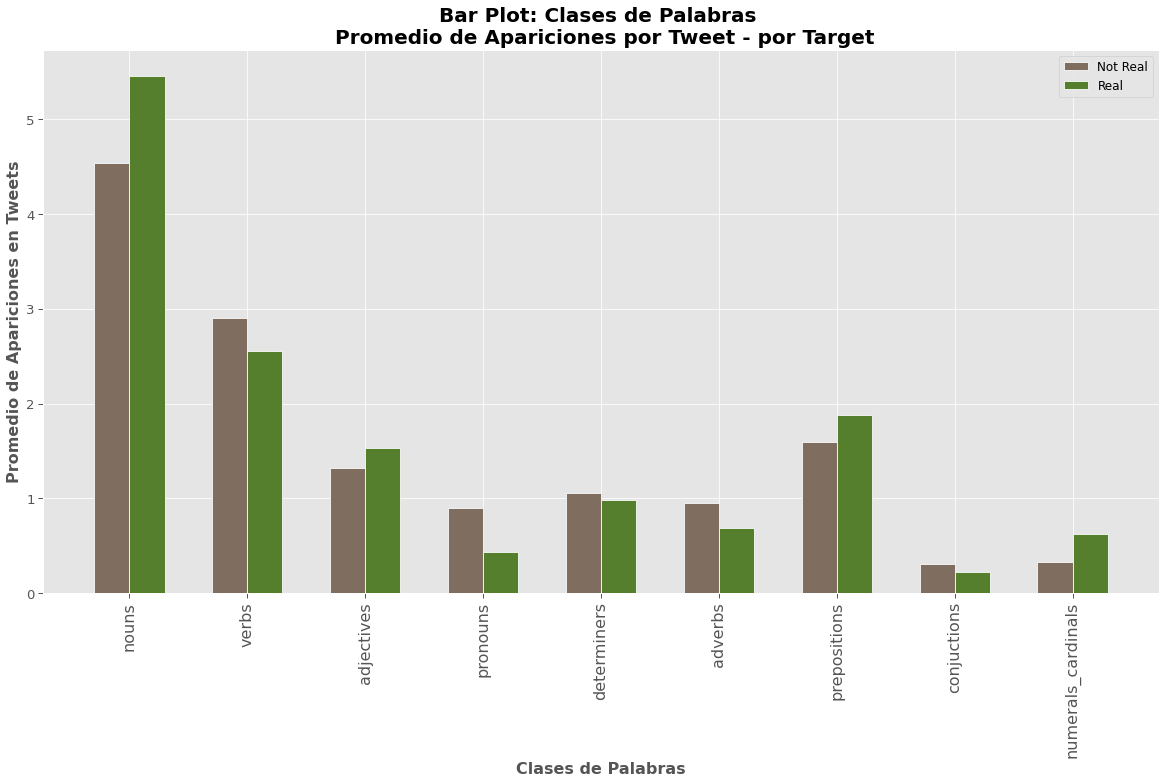

In [104]:
# set width of bar
barWidth = 0.30
 
# set height of bar
target_0 = word_classes_by_target_mean.iloc[0,:].values
target_1 = word_classes_by_target_mean.iloc[1,:].values
xticks_word_tags=list(word_classes_by_target_mean.iloc[0,:].index)

# Set position of bar on X axis
r1 = np.arange(len(target_0))
r2 = [x + barWidth for x in r1]
 
# Make the plot
fig=plt.figure(figsize=(20,10))
plt.bar(r1, target_0, color='#7f6d5f', width=barWidth, edgecolor='white', label='Not Real')
plt.bar(r2, target_1, color='#557f2d', width=barWidth, edgecolor='white', label='Real')
 
# Labels and titles
plt.xlabel('Clases de Palabras', fontweight='bold',fontsize=16)
plt.ylabel('Promedio de Apariciones en Tweets', fontweight='bold',fontsize=16)
plt.xticks([r + 0.15 for r in range(len(target_0))],xticks_word_tags,rotation='vertical',fontsize=16)
plt.title('Bar Plot: Clases de Palabras \n Promedio de Apariciones por Tweet - por Target', fontweight='bold',fontsize=20)

# Create legend & Show graphic
plt.legend(fontsize=12)
plt.show()



In [105]:
#A cuánto se va el porcentaje de target 1 en la muestra cuando en el mismo texto se combinan verbos con advervios
word_classes[(word_classes.loc[:,'verbs']>=1) & (word_classes.loc[:,'adverbs']>=1)]['target'].mean()

0.3459902794653706

In [106]:
#A cuánto se va el porcentaje de target 1 en la muestra cuando en el mismo texto tenemos sustantivos pero no pronombres. 
word_classes[(word_classes.loc[:,'nouns']>=1) & (word_classes.loc[:,'pronouns']==0)]['target'].mean()

0.5050607287449392

In [107]:
#Otra prob cond. 
word_classes[(word_classes.loc[:,'nouns']>=1) & (word_classes.loc[:,'pronouns']==0) & (word_classes.loc[:,'prepositions']>=1) & \
             (word_classes.loc[:,'numerals_cardinals']>=1) & (word_classes.loc[:,'adjectives']>=1) & (word_classes.loc[:,'adverbs']==0)]['target'].mean()

0.674812030075188

In [108]:
#Cuántos registros representan del total. 
(word_classes[(word_classes.loc[:,'nouns']>=1) & (word_classes.loc[:,'pronouns']==0) & (word_classes.loc[:,'prepositions']>=1) & \
             (word_classes.loc[:,'numerals_cardinals']>=1) & (word_classes.loc[:,'adjectives']>=1) & (word_classes.loc[:,'adverbs']==0)].shape[0])/word_classes.shape[0]

0.07722456089417913

In [109]:
#Otra prob cond. 
1-word_classes[(word_classes.loc[:,'prepositions']==0) & 
             (word_classes.loc[:,'numerals_cardinals']==0) & (word_classes.loc[:,'adjectives']==0) & (word_classes.loc[:,'adverbs']>1)]['target'].mean()

0.782608695652174

In [110]:
#Cuántos refistros representa
(word_classes[(word_classes.loc[:,'prepositions']==0) & 
             (word_classes.loc[:,'numerals_cardinals']==0) & (word_classes.loc[:,'adjectives']==0) & (word_classes.loc[:,'adverbs']>1)].shape[0])/word_classes.shape[0]

0.006677311656263609

In [111]:
word_classes['target'].mean()

0.4089127594716214

<function matplotlib.pyplot.show>

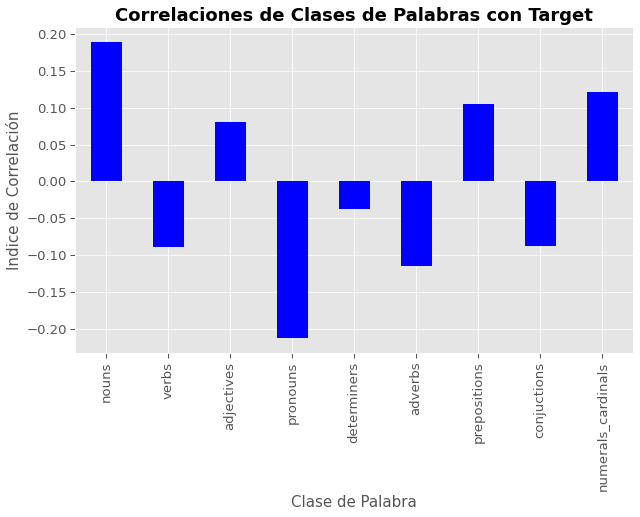

In [112]:
#Correlaciono clase con target
corr_cols=['nouns','verbs','adjectives','pronouns','determiners','adverbs','prepositions','conjuctions','numerals_cardinals','target']
(word_classes.loc[:,corr_cols].corr())['target'][:-1].plot(kind='bar', color='blue', figsize=(10,6))
plt.title('Correlaciones de Clases de Palabras con Target',fontweight='bold', fontsize=18)
plt.ylabel('Indice de Correlación', fontsize=15)
plt.xlabel('Clase de Palabra', fontsize=15)
plt.show

# Análisis de Pronombres

Se propone un análisis de cantidad de apariciones de pronombres en tweets según su target.

In [0]:
def generate_tokens(target):
    text_tokens=[]
    for x in train_no_duplicates[train_no_duplicates['target']==target]['text_clean'].str.split():
        for i in x:
            text_tokens.append(i)
    return text_tokens

#Analizo tweets con target Not Real
corpus=generate_tokens(0)

dic=defaultdict(int)
pronouns={'I','me','my','mine','myself','you','your','yours','yourself',\
          'he','him','his','himself','she','her','hers','herself',\
          'it','its','itself','we','us','our','ours','ourselves',\
          'they','them','their','theirs','themselves','yourselves'}

for word in corpus:
    if word in pronouns:
        dic[word]+=1
        
top0=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:11]


#Analizo tweets con target Real

text_tokens=generate_tokens(1)
dic=defaultdict(int)

for word in text_tokens:
    if word in pronouns:
        dic[word]+=1

top1=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:11]



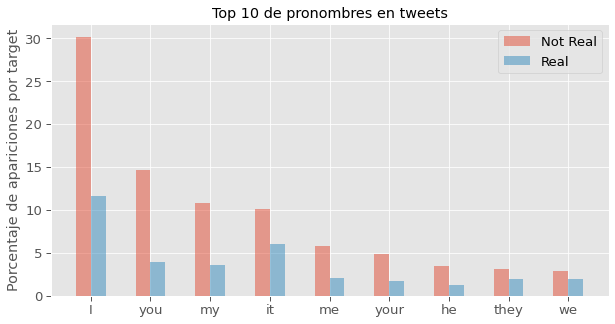

In [114]:
pronouns0=pd.DataFrame(top0,columns=['pronoun','cantidad_not_real'])
pronouns1=pd.DataFrame(top1,columns=['pronoun','cantidad_real'])

pronouns=pronouns0.merge(pronouns1, how='inner')
pronouns['cantidad_not_real']=100*pronouns['cantidad_not_real']/len(train0)
pronouns['cantidad_real']=100*pronouns['cantidad_real']/len(train1)

# Setting the positions and width for the bars
pos = list(range(len(pronouns['pronoun']))) 
width = 0.25 

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with cantidad_not_real data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        pronouns['cantidad_not_real'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with label the first value in first_name
        label=pronouns['pronoun'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        pronouns['cantidad_real'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5,  
        # with label the second value in first_name
        label=pronouns['pronoun'][1]) 

# Set the y axis label
ax.set_ylabel('Porcentaje de apariciones por target')

# Set the chart's title
ax.set_title('Top 10 de pronombres en tweets')


# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(pronouns['pronoun'])


# Adding the legend and showing the plot
plt.legend(['Not Real', 'Real'], loc='upper right')
plt.show()

En la figura se observan los pronombres con más apariciones para ambos targets. Se observa que los mismos 10 pronombres aparecen en ambos rankings. Sin embargo, todos los porcentajes de aparición de target Not Real superan a los de target Real. En partircular, los valores de "I", "you" y "my" para los targets Not Real triplican en porcentaje a los de target Real. 
La naturaleza de un tweet que expresa un desastre responde a un estilo de redacción con poca cantidad de pronombres respecto a un tweet "normal". Esto puede deberse a que no suele usarse la primera ni segunda persona del singular, y puede haber mayor cantidad de nombres propios.

#Analisis de Stopwords 


Se propone un análisis de stopwords. 

In [0]:
sw = stopwords.words("english")

def generate_tokens(target):
    text_tokens=[]
    for x in train_no_duplicates[train_no_duplicates['target']==target]['text_clean'].str.split():
        for i in x:
            text_tokens.append(i)
    return text_tokens

#Analizo stopwords para target Not Real
tokens_0=generate_tokens(0)

dic=defaultdict(int)

for word in tokens_0:
    if word in sw:
        dic[word]+=1

stopwords_0=dic


#Analizo stopwords para target Real

tokens_1=generate_tokens(1)

dic=defaultdict(int)

for word in tokens_1:
    if word in sw:
        dic[word]+=1

stopwords_1=dic


In [116]:
len(tokens_1)/len(train1)

14.34256301029464

In [0]:
stopwords_0=pd.DataFrame.from_dict(stopwords_0,orient='index').reset_index()
stopwords_1=pd.DataFrame.from_dict(stopwords_1,orient='index').reset_index()

In [0]:
stopwords_merged=pd.merge(stopwords_0,stopwords_1,how='outer',on='index')

In [0]:
stopwords_merged.columns=['stopwords','target_0','target_1']

In [0]:
#stopwords_merged['target_0']=pd.to_numeric(stopwords_merged.target_0)
#stopwords_merged['target_1']=pd.to_numeric(stopwords_merged.target_1)
#Normalización
#stopwords_merged['target_0']=(stopwords_merged['target_0']/(len(tokens_0)+len(tokens_1))*100
#stopwords_merged['target_1']=(stopwords_merged['target_1']/(len(tokens_0)+len(tokens_1))*100


In [121]:
stopwords_merged.target_0.fillna(0,inplace=True)
stopwords_merged.target_1.fillna(0,inplace=True)
#stopwords_merged['target_0_freq']=stopwords_merged['target_0']/(stopwords_merged['target_0'].sum())
#stopwords_merged['target_1_freq']=stopwords_merged['target_1']/(stopwords_merged['target_1'].sum())
stopwords_merged['total_count']=stopwords_merged['target_0']+stopwords_merged['target_1']
#stopwords_merged['truthfulness']=(stopwords_merged['target_1']/stopwords_merged['total_count'])

stopwords_merged['if_target1_is_sw']=stopwords_merged['target_1']/(stopwords_merged['target_1'].sum())
stopwords_merged['if_target0_is_sw']=stopwords_merged['target_0']/(stopwords_merged['target_0'].sum())

stopwords_merged['if_sw_is_target1']=stopwords_merged['target_1']/(stopwords_merged['total_count'])
stopwords_merged['if_sw_is_target0']=stopwords_merged['target_0']/(stopwords_merged['total_count'])

stopwords_merged


,stopwords,target_0,target_1,total_count,if_target1_is_sw,if_target0_is_sw,if_sw_is_target1,if_sw_is_target0
0,is,969.0,534.0,"1,503.0",0.0,0.1,0.4,0.6
1,up,180.0,85.0,265.0,0.0,0.0,0.3,0.7
2,so,187.0,48.0,235.0,0.0,0.0,0.2,0.8
3,a,"1,089.0",688.0,"1,777.0",0.1,0.1,0.4,0.6
4,this,228.0,110.0,338.0,0.0,0.0,0.3,0.7
...,...,...,...,...,...,...,...,...
142,above,4.0,2.0,6.0,0.0,0.0,0.3,0.7
143,theirs,1.0,0.0,1.0,0.0,0.0,0.0,1.0
144,hers,0.0,1.0,1.0,0.0,0.0,1.0,0.0
145,ma,0.0,1.0,1.0,0.0,0.0,1.0,0.0


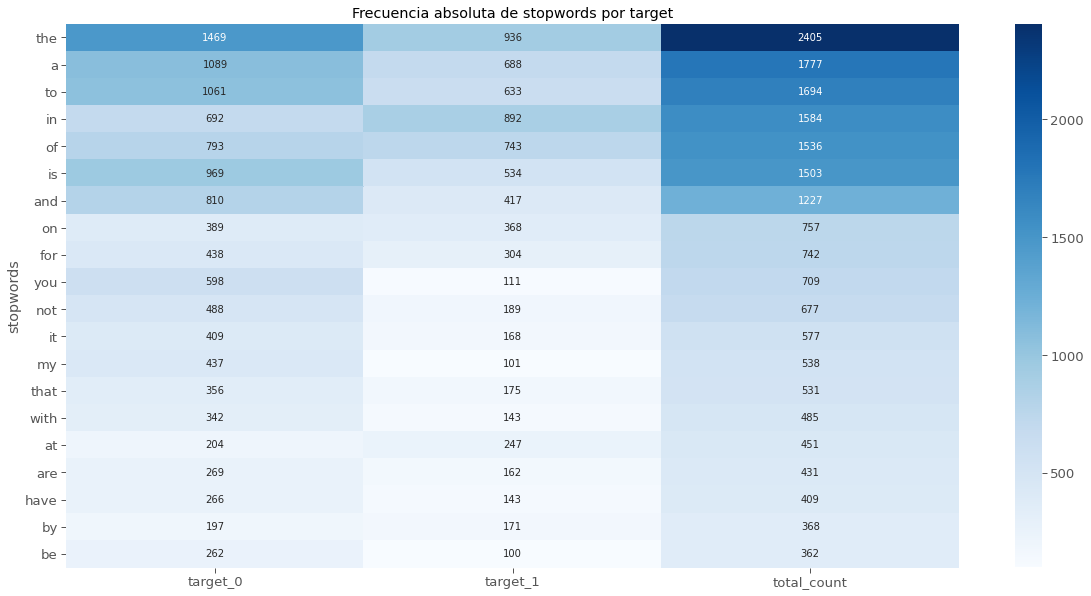

In [122]:
data0=stopwords_merged.loc[:,['stopwords','target_0','target_1','total_count']]
data0=data0.sort_values(by='total_count',ascending=False).head(20)
data0.set_index('stopwords',inplace=True)
fig, ax = plt.subplots(figsize=(20,10))
heat_map = sns.heatmap(data0, annot=True, fmt='g',cmap='Blues')
plt.yticks(rotation=0)
ax.set_title('Frecuencia absoluta de stopwords por target')

plt.show()


# Wordclouds: palabras más utilizadas según target

In [123]:
link='https://drive.google.com/open?id=1HX-1ZTbIXNVLzXIvhEBAPskz53MVXPtx'
fluff, id2 = link.split('=')
print (id2) # Verify that you have everything after '='


1HX-1ZTbIXNVLzXIvhEBAPskz53MVXPtx


In [0]:
downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('twitter_mask.png')


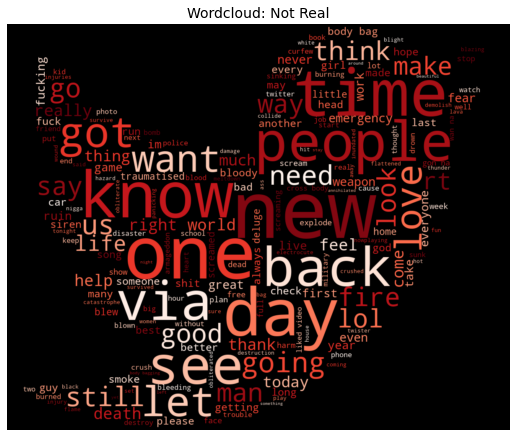

In [125]:

textWordcloud0=(train_no_duplicates[train_no_duplicates['target']==0]['text_clean_no_sw']).str.cat(sep=' ')
wave_mask = np.array(Image.open('twitter_mask.png'))
wordcloud0 = WordCloud(colormap="Reds",mask=wave_mask).generate(textWordcloud0)
# Display the generated image:
f, axes = plt.subplots( figsize=(9, 14), sharex=True)
plt.imshow(wordcloud0, interpolation='bilinear')
axes.set_title('Wordcloud: Not Real',fontsize=14)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


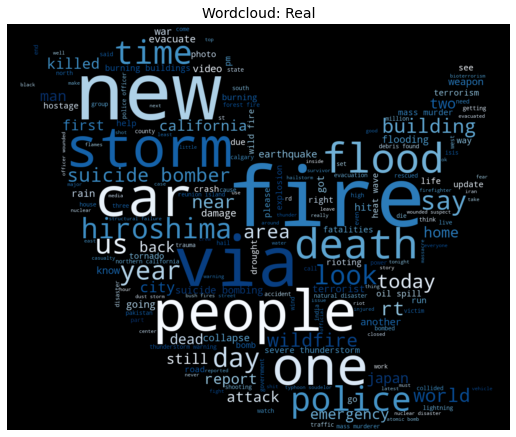

In [126]:
textWordcloud1=(train_no_duplicates[train_no_duplicates['target']==1]['text_clean_no_sw']).str.cat(sep=' ')
mirror=np.fliplr(wave_mask)
wordcloud1 = WordCloud(mask=mirror,colormap="Blues").generate(textWordcloud1)
# Display the generated image:
f, axes = plt.subplots( figsize=(9, 14), sharex=True)
plt.imshow(wordcloud1,interpolation='bilinear')
axes.set_title('Wordcloud: Real',fontsize=14)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# N-gramas

 **1-grama**

Target=0

In [127]:
tokenized=textWordcloud0.split()
unigrams_0 = ngrams(tokenized, 1)
unigramsFreq_0 = collections.Counter(unigrams_0)
unigramsFreq_0.most_common(20)


[(('like',), 247),
 (('get',), 162),
 (('would',), 137),
 (('new',), 135),
 (('one',), 131),
 (('body',), 106),
 (('2',), 102),
 (('got',), 91),
 (('people',), 89),
 (('video',), 89),
 (('via',), 87),
 (('know',), 86),
 (('love',), 85),
 (('day',), 85),
 (('back',), 83),
 (('time',), 82),
 (('see',), 82),
 (('emergency',), 77),
 (('us',), 75),
 (('going',), 75)]

Target=1

In [128]:
tokenized=textWordcloud1.split()
unigrams_1 = ngrams(tokenized, 1)
unigramsFreq_1 = collections.Counter(unigrams_1)
unigramsFreq_1.most_common(20)


[(('fire',), 168),
 (('news',), 115),
 (('police',), 99),
 (('2',), 93),
 (('via',), 93),
 (('disaster',), 91),
 (('people',), 90),
 (('like',), 90),
 (('suicide',), 90),
 (('california',), 89),
 (('storm',), 86),
 (('fires',), 81),
 (('hiroshima',), 78),
 (('killed',), 75),
 (('emergency',), 74),
 (('crash',), 70),
 (('nuclear',), 69),
 (('buildings',), 67),
 (('accident',), 65),
 (('one',), 64)]

**2-gramas**


Target=0

In [129]:
tokenized=textWordcloud0.split()
bigrams_0 = ngrams(tokenized, 2)
bigramsFreq_0 = collections.Counter(bigrams_0)
bigramsFreq_0.most_common(20)



[(('gon', 'na'), 32),
 (('cross', 'body'), 31),
 (('liked', 'video'), 30),
 (('wan', 'na'), 30),
 (('body', 'bagging'), 24),
 (('looks', 'like'), 21),
 (('body', 'bags'), 21),
 (('burning', 'buildings'), 19),
 (('loud', 'bang'), 19),
 (('body', 'bag'), 18),
 (('feel', 'like'), 17),
 (('first', 'responders'), 17),
 (('pick', 'fan'), 16),
 (('fan', 'army'), 16),
 (('fall', 'cliff'), 16),
 (('full', 'read'), 15),
 (('ignition', 'knock'), 15),
 (('knock', 'detonation'), 15),
 (('detonation', 'sensor'), 15),
 (('war', 'zone'), 15)]

Target= 1

In [130]:
tokenized=textWordcloud1.split()
bigrams_1 = ngrams(tokenized, 2)
bigramsFreq_1 = collections.Counter(bigrams_1)
bigramsFreq_1.most_common(20)

[(('suicide', 'bomber'), 41),
 (('suicide', 'bombing'), 34),
 (('burning', 'buildings'), 28),
 (('oil', 'spill'), 28),
 (('severe', 'thunderstorm'), 26),
 (('mass', 'murder'), 26),
 (('wild', 'fires'), 25),
 (('heat', 'wave'), 23),
 (('debris', 'found'), 22),
 (('70', 'years'), 22),
 (('natural', 'disaster'), 20),
 (('thunderstorm', 'warning'), 20),
 (('mass', 'murderer'), 19),
 (('reunion', 'island'), 18),
 (('northern', 'california'), 18),
 (('typhoon', 'soudelor'), 18),
 (('officer', 'wounded'), 18),
 (('08', '05'), 17),
 (('dust', 'storm'), 17),
 (('nuclear', 'disaster'), 17)]

**3-grama**

Target=0

In [131]:
tokenized=textWordcloud0.split()
trigrams_0 = ngrams(tokenized, 3)
trigramsFreq_0 = collections.Counter(trigrams_0)
trigramsFreq_0.most_common(20)

[(('pick', 'fan', 'army'), 16),
 (('ignition', 'knock', 'detonation'), 15),
 (('knock', 'detonation', 'sensor'), 15),
 (('breaking', 'news', 'unconfirmed'), 13),
 (('news', 'unconfirmed', 'heard'), 13),
 (('unconfirmed', 'heard', 'loud'), 13),
 (('heard', 'loud', 'bang'), 13),
 (('loud', 'bang', 'nearby'), 13),
 (('bang', 'nearby', 'appears'), 13),
 (('nearby', 'appears', 'blast'), 13),
 (('appears', 'blast', 'wind'), 13),
 (('blast', 'wind', 'neighbour'), 13),
 (('wind', 'neighbour', 'ass'), 13),
 (('china', 'stock', 'market'), 13),
 (('stock', 'market', 'crash'), 13),
 (('added', 'video', 'playlist'), 11),
 (('cross', 'body', 'bag'), 11),
 (('reddit', 'quarantine', 'offensive'), 11),
 (('wreck', 'wreck', 'wreck'), 11),
 (('top', 'pay', 'pile'), 10)]

Target=1

In [132]:
tokenized=textWordcloud1.split()
trigrams_1 = ngrams(tokenized, 3)
trigramsFreq_1 = collections.Counter(trigrams_1)
trigramsFreq_1.most_common(20)

[(('severe', 'thunderstorm', 'warning'), 20),
 (('officer', 'wounded', 'suspect'), 17),
 (('suicide', 'bomber', 'detonated'), 15),
 (('suicide', 'bomber', 'kills'), 14),
 (('police', 'officer', 'wounded'), 14),
 (('found', 'reunion', 'island'), 13),
 (('refugio', 'oil', 'spill'), 13),
 (('oil', 'spill', 'may'), 13),
 (('spill', 'may', 'costlier'), 13),
 (('may', 'costlier', 'bigger'), 13),
 (('costlier', 'bigger', 'projected'), 13),
 (('pkk', 'suicide', 'bomber'), 13),
 (('bomber', 'detonated', 'bomb'), 13),
 (('outrage', 'amid', 'crisis'), 12),
 (('16yr', 'old', 'pkk'), 12),
 (('old', 'pkk', 'suicide'), 12),
 (('detonated', 'bomb', 'turkey'), 12),
 (('bomb', 'turkey', 'army'), 12),
 (('turkey', 'army', 'trench'), 12),
 (('bomber', 'kills', '15'), 12)]

Unigramas que solo aparecen en target 1/ target 0

In [0]:
unigrams_frecuencies0 = pd.DataFrame.from_dict(unigramsFreq_0, orient='index').reset_index()
unigrams_frecuencies1 = pd.DataFrame.from_dict(unigramsFreq_1, orient='index').reset_index()
#MERGE INNER / OUTER
unigrams_frecuencies_inner=pd.merge(unigrams_frecuencies0,unigrams_frecuencies1,on='index')
unigrams_frecuencies_outer=pd.merge(unigrams_frecuencies0,unigrams_frecuencies1,on='index', how='outer')


In [0]:
unigrams_frecuencies_inner.columns=['words','target0','target1']
unigrams_frecuencies_inner['total']=unigrams_frecuencies_inner['target0']+unigrams_frecuencies_inner['target1']

In [0]:
unigrams_frecuencies_outer.columns=['words','target0','target1']
unigrams_frecuencies_outer.fillna(0,inplace=True)
unigrams_frecuencies_outer['total']=unigrams_frecuencies_outer['target0']+unigrams_frecuencies_outer['target1']

#unigrams_frecuencies_outer['target0']=unigrams_frecuencies_outer['target0'].fillna(0)
#unigrams_frecuencies_outer['target1']=unigrams_frecuencies_outer['target1'].fillna(0)

unigrams_only_target1=unigrams_frecuencies_outer[unigrams_frecuencies_outer['target0']==0]
unigrams_only_target0=unigrams_frecuencies_outer[unigrams_frecuencies_outer['target1']==0]


In [0]:
unigrams_only_target1.drop('target0',axis=1,inplace=True)
unigrams_only_target0.drop('target1',axis=1,inplace=True)


unigrams_only_target1.sort_values(by='target1',ascending=False,inplace=True)
unigrams_only_target0.sort_values(by='target0',ascending=False,inplace=True)


Text(0.5, 0, 'Frecuencia absoluta')

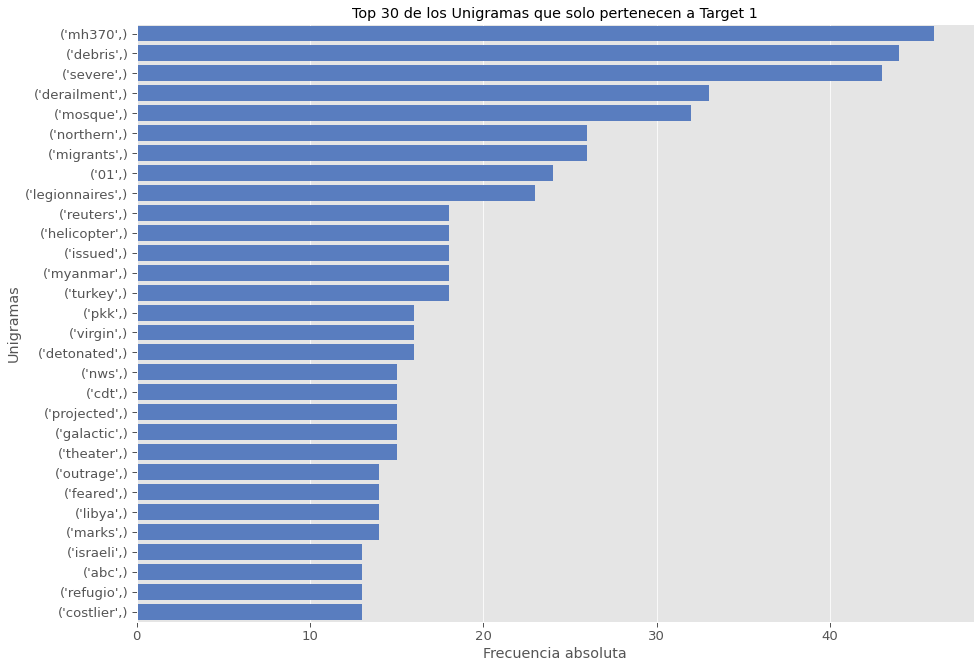

In [137]:
fig, ax = plt.subplots(figsize=(15,11))
sns.set_color_codes("muted")
sns.barplot(x="target1", y="words", 
            data=unigrams_only_target1.head(30), color='b',
            label="bigrams", 
            orient = "h")
ax.set_title('Top 30 de los Unigramas que solo pertenecen a Target 1')
ax.set_ylabel('Unigramas')
ax.set_xlabel('Frecuencia absoluta')

Text(0.5, 0, 'Frecuencia absoluta')

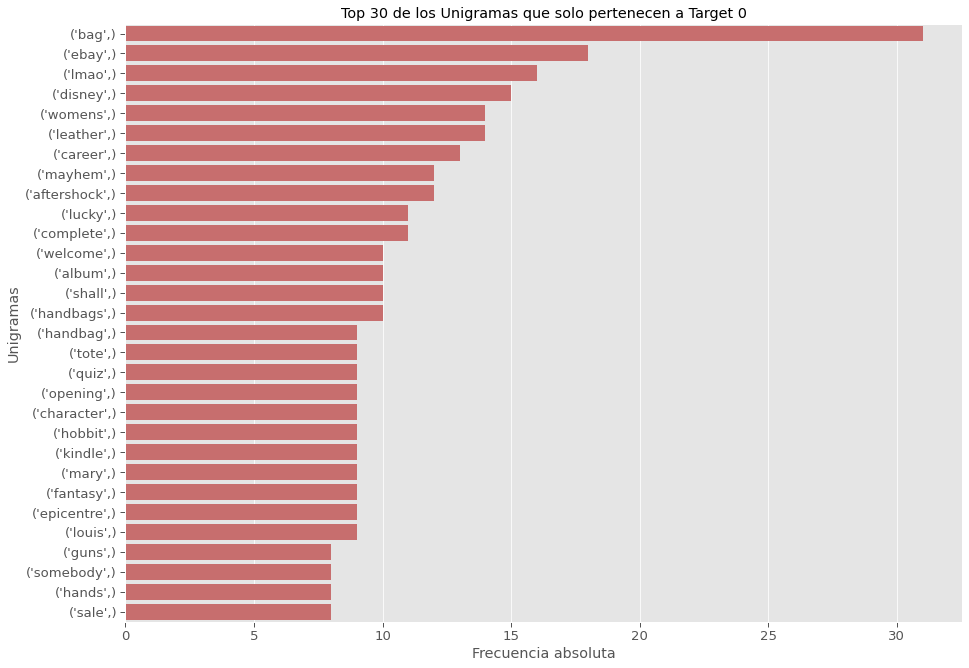

In [138]:
fig, ax = plt.subplots(figsize=(15,11))
sns.set_color_codes("muted")
sns.barplot(x="target0", y="words", 
            data=unigrams_only_target0.head(30),
            label="bigrams", color='r',
            orient = "h")
ax.set_title('Top 30 de los Unigramas que solo pertenecen a Target 0')
ax.set_ylabel('Unigramas')
ax.set_xlabel('Frecuencia absoluta')

Unigramas que aparecen tanto en target 1 como en target 0

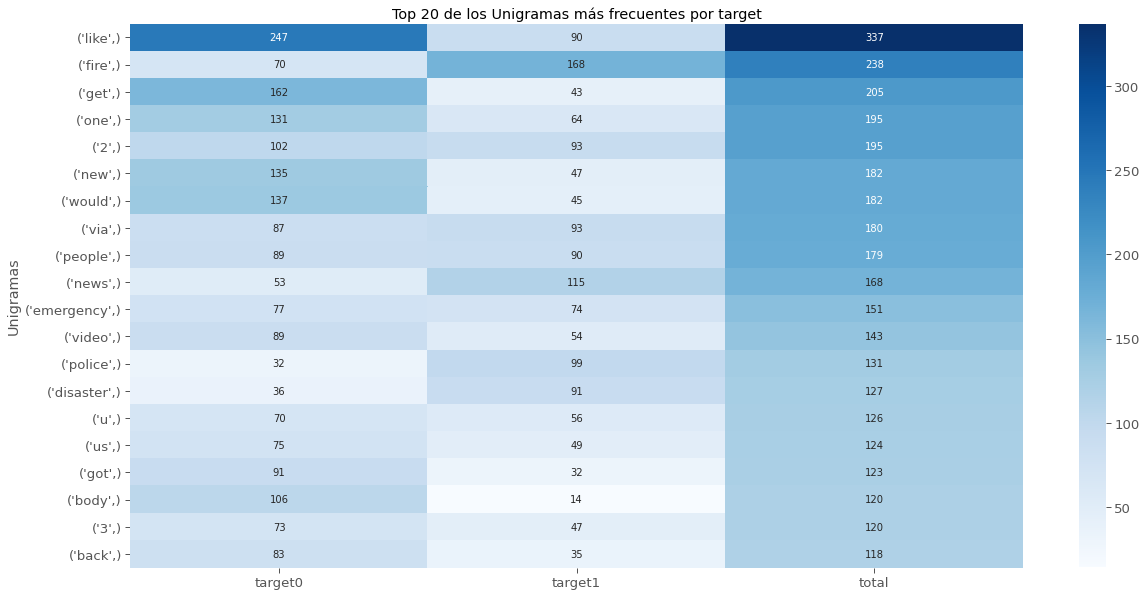

In [139]:
aux_uni=(unigrams_frecuencies_inner.sort_values(by='total', ascending=False))
aux_uni.set_index('words',inplace=True)

fig, ax = plt.subplots(figsize=(20,10))

heat_map = sns.heatmap(aux_uni.head(20),annot=True, fmt='g',cmap='Blues')
plt.yticks(rotation=0)
ax.set_title('Top 20 de los Unigramas más frecuentes por target')
ax.set_ylabel('Unigramas')

plt.show()

In [140]:
aux_uni['target0_norm']=100*aux_uni['target0']/(aux_uni['target0']+aux_uni['target1'])
aux_uni['target1_norm']=100*aux_uni['target1']/(aux_uni['target0']+aux_uni['target1'])
aux_uni=aux_uni.head(20)
aux_uni.sort_values(by='target0_norm',ascending=False,inplace=True)
aux_uni.reset_index(inplace=True)
aux_uni

,words,target0,target1,total,target0_norm,target1_norm
0,"(body,)",106,14,120,88.3,11.7
1,"(get,)",162,43,205,79.0,21.0
2,"(would,)",137,45,182,75.3,24.7
3,"(new,)",135,47,182,74.2,25.8
4,"(got,)",91,32,123,74.0,26.0
5,"(like,)",247,90,337,73.3,26.7
6,"(back,)",83,35,118,70.3,29.7
7,"(one,)",131,64,195,67.2,32.8
8,"(video,)",89,54,143,62.2,37.8
9,"(3,)",73,47,120,60.8,39.2


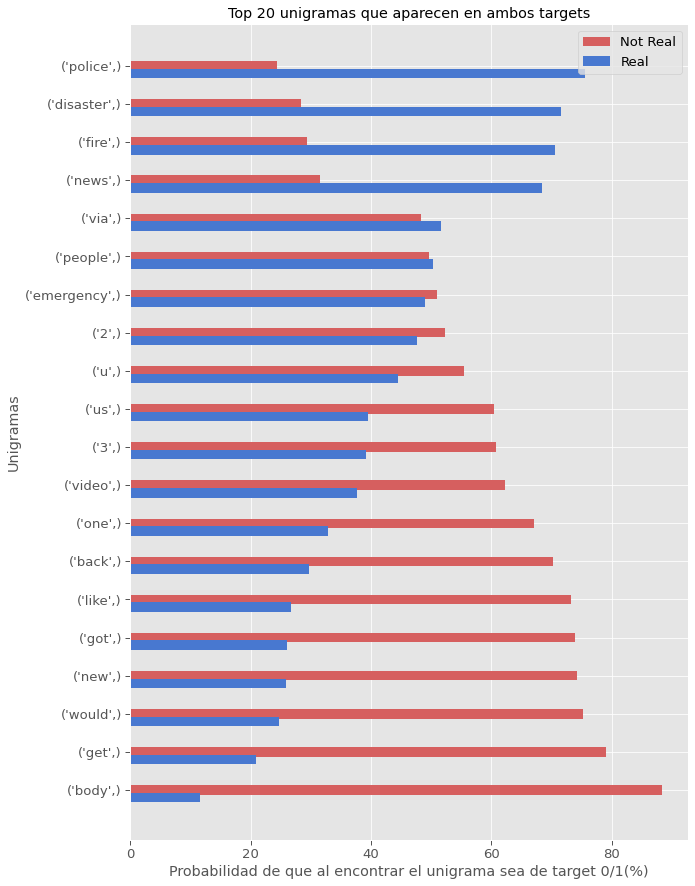

In [141]:
fig, ax = plt.subplots(figsize=(10,15)) 
width=0.25
ax.barh(aux_uni.index,aux_uni['target0_norm'],width,color='r',label='Not Real')
ax.barh(aux_uni.index-0.2,aux_uni['target1_norm'],width,color = 'b',label='Real')
plt.yticks(aux_uni.index, aux_uni['words'])
ax.set_title('Top 20 unigramas que aparecen en ambos targets')
ax.set_ylabel('Unigramas')
ax.set_xlabel('Probabilidad de que al encontrar el unigrama sea de target 0/1(%)')
ax.legend(ncol=1, loc="upper right", frameon=True)
plt.show()


Bigramas que aparecen en ambos targets

In [0]:
bigrams_frecuencies0 = pd.DataFrame.from_dict(bigramsFreq_0, orient='index').reset_index()
bigrams_frecuencies1 = pd.DataFrame.from_dict(bigramsFreq_1, orient='index').reset_index()
#MERGE INNER / OUTER
bigrams_frecuencies_inner=pd.merge(bigrams_frecuencies0,bigrams_frecuencies1,on='index')
bigrams_frecuencies_outer=pd.merge(bigrams_frecuencies0,bigrams_frecuencies1,on='index', how='outer')


In [0]:
bigrams_frecuencies_inner.columns=['words','target0','target1']
bigrams_frecuencies_inner['total']=bigrams_frecuencies_inner['target0']+bigrams_frecuencies_inner['target1']

bigrams_frecuencies_outer.columns=['words','target0','target1']
bigrams_frecuencies_outer.fillna(0,inplace=True)
bigrams_frecuencies_outer['total']=bigrams_frecuencies_outer['target0']+bigrams_frecuencies_outer['target1']


In [0]:
bigrams_only_target1=bigrams_frecuencies_outer[bigrams_frecuencies_outer['target0']==0]
bigrams_only_target0=bigrams_frecuencies_outer[bigrams_frecuencies_outer['target1']==0]


In [0]:
bigrams_only_target1.drop('target0',axis=1,inplace=True)
bigrams_only_target0.drop('target1',axis=1,inplace=True)


bigrams_only_target1.sort_values(by='target1',ascending=False,inplace=True)
bigrams_only_target0.sort_values(by='target0',ascending=False,inplace=True)


Text(0.5, 0, 'Frecuencia absoluta')

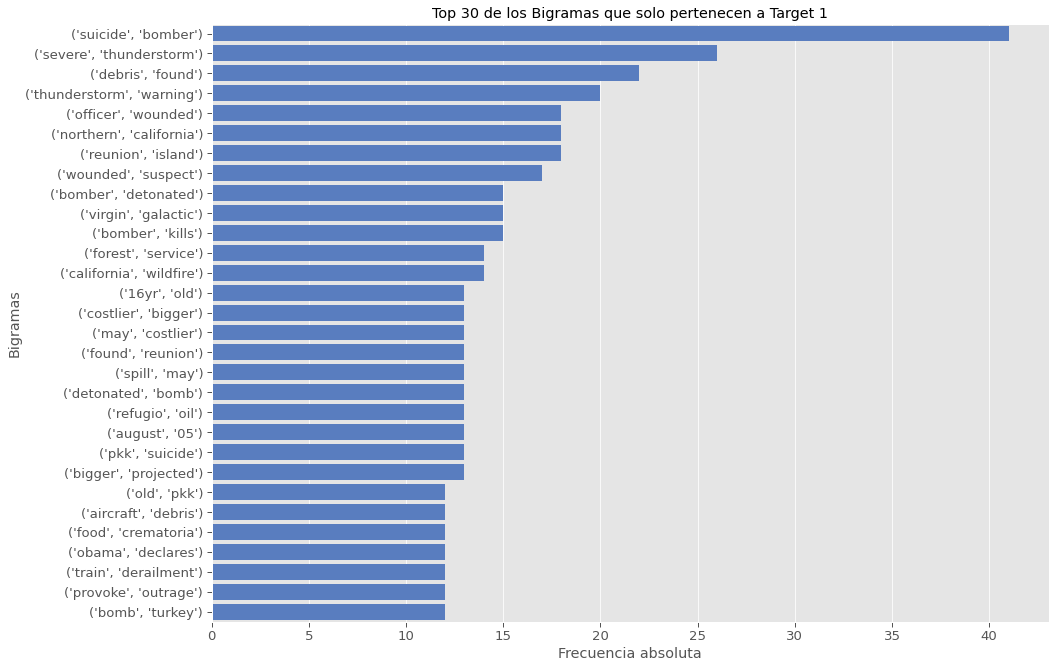

In [146]:
fig, ax = plt.subplots(figsize=(15,11))
sns.set_color_codes("muted")
sns.barplot(x="target1", y="words", 
            data=bigrams_only_target1.head(30),
            label="bigrams", color='b',
            orient = "h")
ax.set_title('Top 30 de los Bigramas que solo pertenecen a Target 1')
ax.set_ylabel('Bigramas')
ax.set_xlabel('Frecuencia absoluta')

Text(0.5, 0, 'Frecuencia absoluta')

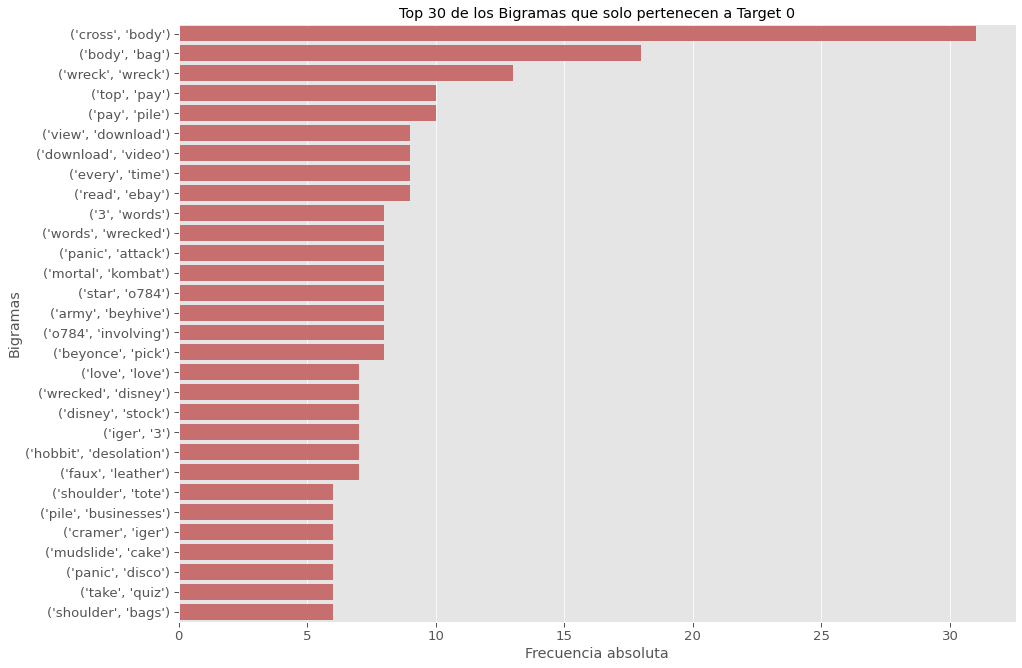

In [147]:
fig, ax = plt.subplots(figsize=(15,11))
sns.set_color_codes("muted")
sns.barplot(x="target0", y="words", 
            data=bigrams_only_target0.head(30),
            label="bigrams", color='r',
            orient = "h")
ax.set_title('Top 30 de los Bigramas que solo pertenecen a Target 0')
ax.set_ylabel('Bigramas')
ax.set_xlabel('Frecuencia absoluta')

Bigramas que aparecen tanto en target 1 como en target 0

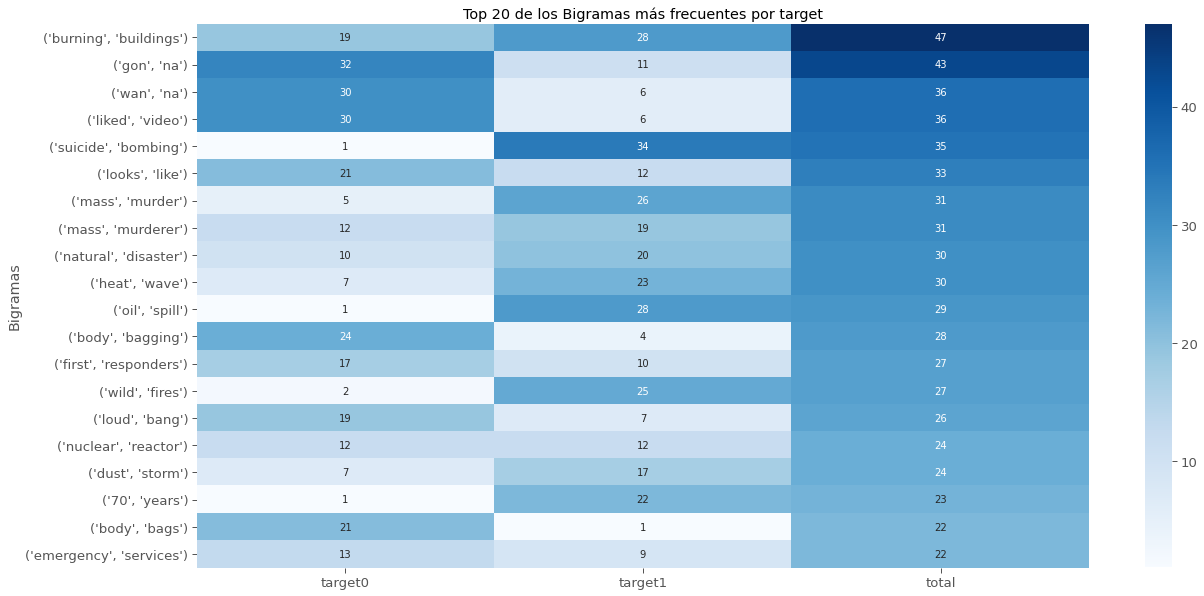

In [148]:
aux_uni=(bigrams_frecuencies_inner.sort_values(by='total', ascending=False))
aux_uni.set_index('words',inplace=True)

fig, ax = plt.subplots(figsize=(20,10))

heat_map = sns.heatmap(aux_uni.head(20),annot=True, fmt='g',cmap='Blues')
plt.yticks(rotation=0)
ax.set_title('Top 20 de los Bigramas más frecuentes por target')
ax.set_ylabel('Bigramas')

plt.show()

In [149]:
aux_uni['target0_norm']=100*aux_uni['target0']/(aux_uni['target0']+aux_uni['target1'])
aux_uni['target1_norm']=100*aux_uni['target1']/(aux_uni['target0']+aux_uni['target1'])
aux_uni=aux_uni.head(20)
aux_uni.sort_values(by='target0_norm',ascending=False,inplace=True)
aux_uni.reset_index(inplace=True)
aux_uni


,words,target0,target1,total,target0_norm,target1_norm
0,"(body, bags)",21,1,22,95.5,4.5
1,"(body, bagging)",24,4,28,85.7,14.3
2,"(wan, na)",30,6,36,83.3,16.7
3,"(liked, video)",30,6,36,83.3,16.7
4,"(gon, na)",32,11,43,74.4,25.6
5,"(loud, bang)",19,7,26,73.1,26.9
6,"(looks, like)",21,12,33,63.6,36.4
7,"(first, responders)",17,10,27,63.0,37.0
8,"(emergency, services)",13,9,22,59.1,40.9
9,"(nuclear, reactor)",12,12,24,50.0,50.0


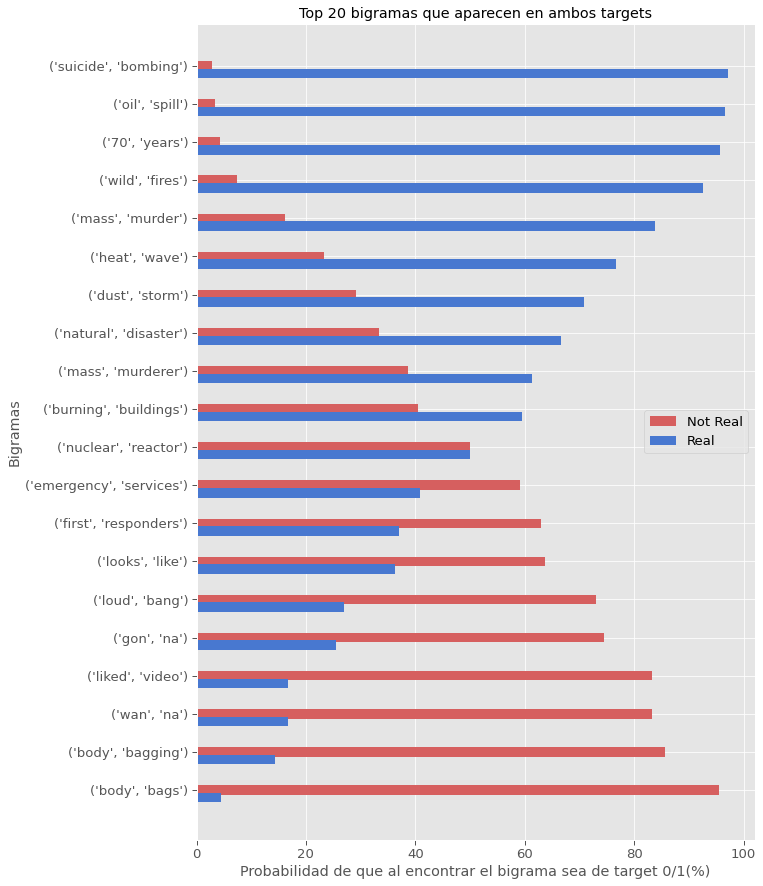

In [150]:
fig, ax = plt.subplots(figsize=(10,15)) 
width=0.25
ax.barh(aux_uni.index,aux_uni['target0_norm'],width,color='r',label='Not Real')
ax.barh(aux_uni.index-0.2,aux_uni['target1_norm'],width,color = 'b',label='Real')
plt.yticks(aux_uni.index, aux_uni['words'])
ax.set_title('Top 20 bigramas que aparecen en ambos targets')
ax.set_ylabel('Bigramas')
ax.set_xlabel('Probabilidad de que al encontrar el bigrama sea de target 0/1(%)')
ax.legend(ncol=1, loc="middle right", frameon=True)
plt.show()


Trigramas que aparecen en ambos targets

In [0]:
trigrams_frecuencies0 = pd.DataFrame.from_dict(trigramsFreq_0, orient='index').reset_index()
trigrams_frecuencies1 = pd.DataFrame.from_dict(trigramsFreq_1, orient='index').reset_index()
#MERGE INNER / OUTER
trigrams_frecuencies_inner=pd.merge(trigrams_frecuencies0,trigrams_frecuencies1,on='index')
trigrams_frecuencies_outer=pd.merge(trigrams_frecuencies0,trigrams_frecuencies1,on='index', how='outer')


In [152]:
trigrams_frecuencies_inner.columns=['words','target0','target1']
trigrams_frecuencies_inner['total']=trigrams_frecuencies_inner['target0']+trigrams_frecuencies_inner['target1']

trigrams_frecuencies_outer.columns=['words','target0','target1']
trigrams_frecuencies_outer.fillna(0,inplace=True)
trigrams_frecuencies_outer['total']=trigrams_frecuencies_outer['target0']+trigrams_frecuencies_outer['target1']
trigrams_frecuencies_outer

,words,target0,target1,total
0,"(man, love, fruits)",1.0,0.0,1.0
1,"(love, fruits, summer)",1.0,0.0,1.0
2,"(fruits, summer, lovely)",1.0,0.0,1.0
3,"(summer, lovely, car)",1.0,0.0,1.0
4,"(lovely, car, fast)",1.0,0.0,1.0
...,...,...,...,...
56482,"(mosque, reuters, via)",0.0,1.0,1.0
56483,"(reuters, via, world)",0.0,1.0,1.0
56484,"(via, world, google)",0.0,1.0,1.0
56485,"(world, google, news)",0.0,1.0,1.0


In [0]:
trigrams_only_target1=trigrams_frecuencies_outer[trigrams_frecuencies_outer['target0']==0]
trigrams_only_target0=trigrams_frecuencies_outer[trigrams_frecuencies_outer['target1']==0]


In [0]:
trigrams_only_target1.drop('target0',axis=1,inplace=True)
trigrams_only_target0.drop('target1',axis=1,inplace=True)


trigrams_only_target1.sort_values(by='target1',ascending=False,inplace=True)
trigrams_only_target0.sort_values(by='target0',ascending=False,inplace=True)


Text(0.5, 0, 'Frecuencia absoluta')

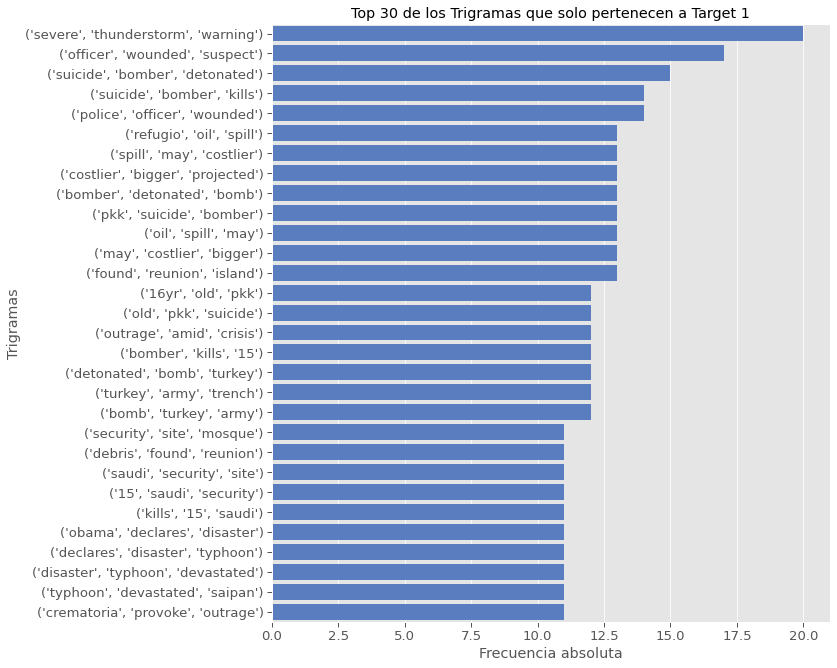

In [155]:
fig, ax = plt.subplots(figsize=(10,11))
sns.set_color_codes(palette="muted")
sns.barplot(x="target1", y="words", 
            data=trigrams_only_target1.head(30),
            label="trigrams", 
            orient = "h",color='b')
ax.set_title('Top 30 de los Trigramas que solo pertenecen a Target 1')
ax.set_ylabel('Trigramas')
ax.set_xlabel('Frecuencia absoluta')

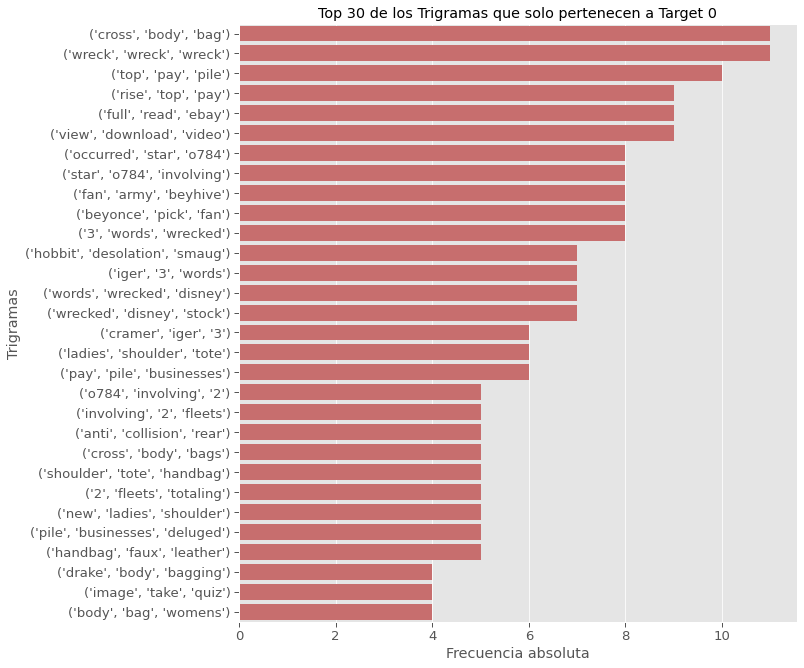

In [156]:
fig, ax = plt.subplots(figsize=(10,11))
sns.set_color_codes(palette="muted")
sns.barplot(x="target0", y="words", 
            data=trigrams_only_target0.head(30),
            label="trigrams", 
            orient = "h", color='r')
ax.set_title('Top 30 de los Trigramas que solo pertenecen a Target 0')
ax.set_ylabel('Trigramas')
ax.set_xlabel('Frecuencia absoluta')
plt.show()

Trigramas que aparecen tanto en target 1 como en target 0

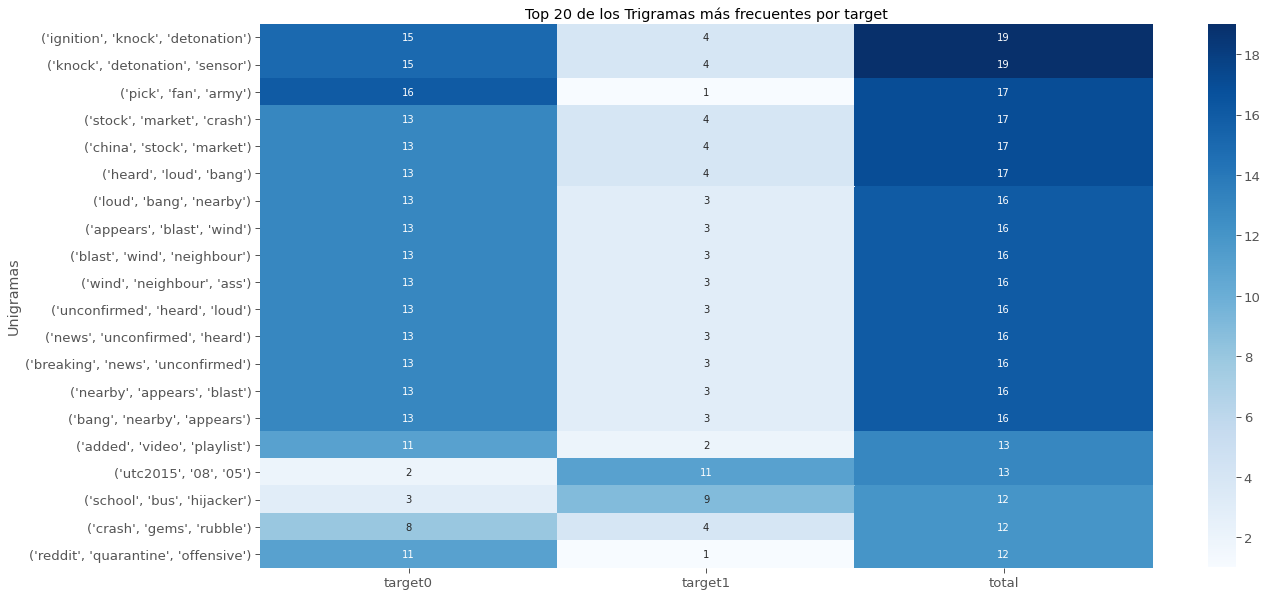

In [157]:
aux_uni=(trigrams_frecuencies_inner.sort_values(by='total', ascending=False))
aux_uni.set_index('words',inplace=True)

fig, ax = plt.subplots(figsize=(20,10))

heat_map = sns.heatmap(aux_uni.head(20),annot=True, fmt='g',cmap='Blues')
plt.yticks(rotation=0)
ax.set_title('Top 20 de los Trigramas más frecuentes por target')
ax.set_ylabel('Unigramas')

plt.show()

In [158]:
aux_uni

,target0,target1,total
words,,,
"(ignition, knock, detonation)",15,4,19
"(knock, detonation, sensor)",15,4,19
"(pick, fan, army)",16,1,17
"(stock, market, crash)",13,4,17
"(china, stock, market)",13,4,17
...,...,...,...
"(elephant, population, declined)",1,1,2
"(tanzania, elephant, population)",1,1,2
"(day, providence, health)",1,1,2


In [159]:
#aux_uni.drop('index',axis=1,inplace=True)
#aux_uni.reset_index(inplace=True)
aux_uni['target0_norm']=100*aux_uni['target0']/(aux_uni['target0']+aux_uni['target1'])
aux_uni['target1_norm']=100*aux_uni['target1']/(aux_uni['target0']+aux_uni['target1'])
aux_uni=aux_uni.head(20)
aux_uni.sort_values(by='target0_norm',ascending=False,inplace=True)
aux_uni.reset_index(inplace=True)
aux_uni


,words,target0,target1,total,target0_norm,target1_norm
0,"(pick, fan, army)",16,1,17,94.1,5.9
1,"(reddit, quarantine, offensive)",11,1,12,91.7,8.3
2,"(added, video, playlist)",11,2,13,84.6,15.4
3,"(wind, neighbour, ass)",13,3,16,81.2,18.8
4,"(bang, nearby, appears)",13,3,16,81.2,18.8
5,"(nearby, appears, blast)",13,3,16,81.2,18.8
6,"(breaking, news, unconfirmed)",13,3,16,81.2,18.8
7,"(news, unconfirmed, heard)",13,3,16,81.2,18.8
8,"(unconfirmed, heard, loud)",13,3,16,81.2,18.8
9,"(blast, wind, neighbour)",13,3,16,81.2,18.8


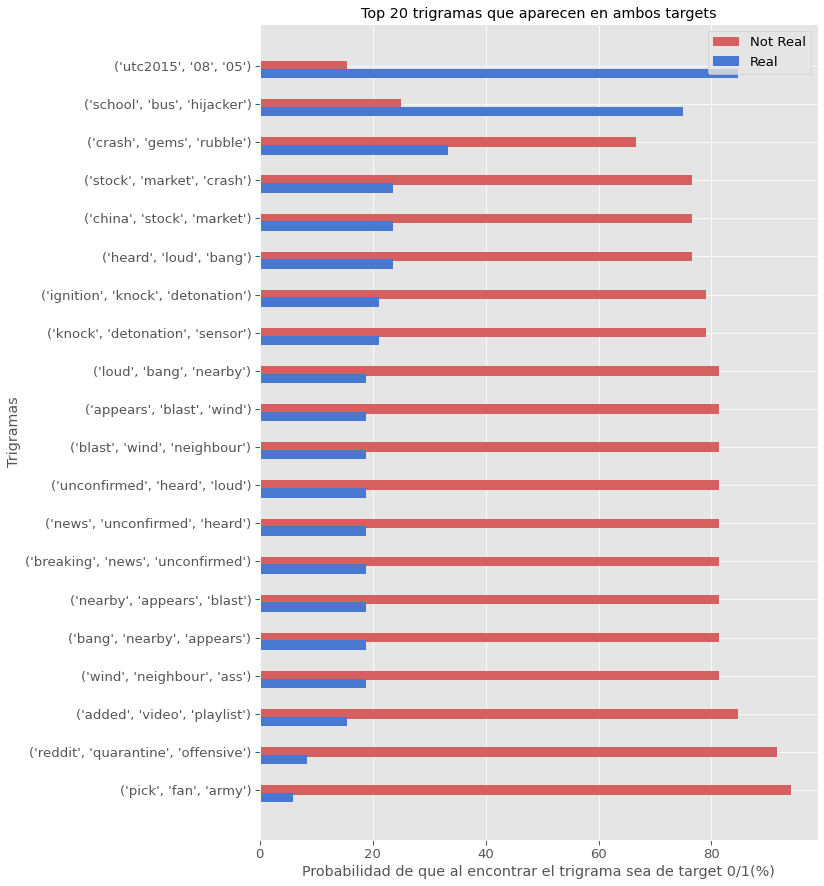

In [160]:
fig, ax = plt.subplots(figsize=(10,15)) 
width=0.25
ax.barh(aux_uni.index,aux_uni['target0_norm'],width,color='r',label='Not Real')
ax.barh(aux_uni.index-0.2,aux_uni['target1_norm'],width,color = 'b',label='Real')
plt.yticks(aux_uni.index, aux_uni['words'])
ax.set_title('Top 20 trigramas que aparecen en ambos targets')
ax.set_ylabel('Trigramas')
ax.set_xlabel('Probabilidad de que al encontrar el trigrama sea de target 0/1(%)')
ax.legend(ncol=1, loc="upper right", frameon=True)
plt.show()


In [161]:
aux_uni.index

RangeIndex(start=0, stop=20, step=1)

## Análisis de paises encontrados en el texto

In [162]:
!pip install pycountry
import pycountry

     |████████████████████████████████| 10.0MB 2.5MB/s 
  Created wheel for pycountry: filename=pycountry-19.8.18-py2.py3-none-any.whl size=10627361 sha256=77ba18851e643096605dc5998ba300a449a44e6182066c4012eaaf444119b56a
  Stored in directory: /root/.cache/pip/wheels/a2/98/bf/f0fa1c6bf8cf2cbdb750d583f84be51c2cd8272460b8b36bd3
Successfully built pycountry


In [0]:
Country = [
    ('US', 'United States'),
    ('AF', 'Afghanistan'),
    ('AL', 'Albania'),
    ('DZ', 'Algeria'),
    ('AS', 'American Samoa'),
    ('AD', 'Andorra'),
    ('AO', 'Angola'),
    ('AI', 'Anguilla'),
    ('AQ', 'Antarctica'),
    ('AG', 'Antigua And Barbuda'),
    ('AR', 'Argentina'),
    ('AM', 'Armenia'),
    ('AW', 'Aruba'),
    ('AU', 'Australia'),
    ('AT', 'Austria'),
    ('AZ', 'Azerbaijan'),
    ('BS', 'Bahamas'),
    ('BH', 'Bahrain'),
    ('BD', 'Bangladesh'),
    ('BB', 'Barbados'),
    ('BY', 'Belarus'),
    ('BE', 'Belgium'),
    ('BZ', 'Belize'),
    ('BJ', 'Benin'),
    ('BM', 'Bermuda'),
    ('BT', 'Bhutan'),
    ('BO', 'Bolivia'),
    ('BA', 'Bosnia And Herzegowina'),
    ('BW', 'Botswana'),
    ('BV', 'Bouvet Island'),
    ('BR', 'Brazil'),
    ('BN', 'Brunei Darussalam'),
    ('BG', 'Bulgaria'),
    ('BF', 'Burkina Faso'),
    ('BI', 'Burundi'),
    ('KH', 'Cambodia'),
    ('CM', 'Cameroon'),
    ('CA', 'Canada'),
    ('CV', 'Cape Verde'),
    ('KY', 'Cayman Islands'),
    ('CF', 'Central African Rep'),
    ('TD', 'Chad'),
    ('CL', 'Chile'),
    ('CN', 'China'),
    ('CX', 'Christmas Island'),
    ('CC', 'Cocos Islands'),
    ('CO', 'Colombia'),
    ('KM', 'Comoros'),
    ('CG', 'Congo'),
    ('CK', 'Cook Islands'),
    ('CR', 'Costa Rica'),
    ('CI', 'Cote D`ivoire'),
    ('HR', 'Croatia'),
    ('CU', 'Cuba'),
    ('CY', 'Cyprus'),
    ('CZ', 'Czech Republic'),
    ('DK', 'Denmark'),
    ('DJ', 'Djibouti'),
    ('DM', 'Dominica'),
    ('DO', 'Dominican Republic'),
    ('TP', 'East Timor'),
    ('EC', 'Ecuador'),
    ('EG', 'Egypt'),
    ('SV', 'El Salvador'),
    ('GQ', 'Equatorial Guinea'),
    ('ER', 'Eritrea'),
    ('EE', 'Estonia'),
    ('ET', 'Ethiopia'),
    ('FK', 'Falkland Islands (Malvinas)'),
    ('FO', 'Faroe Islands'),
    ('FJ', 'Fiji'),
    ('FI', 'Finland'),
    ('FR', 'France'),
    ('GF', 'French Guiana'),
    ('PF', 'French Polynesia'),
    ('TF', 'French S. Territories'),
    ('GA', 'Gabon'),
    ('GM', 'Gambia'),
    ('GE', 'Georgia'),
    ('DE', 'Germany'),
    ('GH', 'Ghana'),
    ('GI', 'Gibraltar'),
    ('GR', 'Greece'),
    ('GL', 'Greenland'),
    ('GD', 'Grenada'),
    ('GP', 'Guadeloupe'),
    ('GU', 'Guam'),
    ('GT', 'Guatemala'),
    ('GN', 'Guinea'),
    ('GW', 'Guinea-bissau'),
    ('GY', 'Guyana'),
    ('HT', 'Haiti'),
    ('HN', 'Honduras'),
    ('HK', 'Hong Kong'),
    ('HU', 'Hungary'),
    ('IS', 'Iceland'),
    ('IN', 'India'),
    ('ID', 'Indonesia'),
    ('IR', 'Iran'),
    ('IQ', 'Iraq'),
    ('IE', 'Ireland'),
    ('IL', 'Israel'),
    ('IT', 'Italy'),
    ('JM', 'Jamaica'),
    ('JP', 'Japan'),
    ('JO', 'Jordan'),
    ('KZ', 'Kazakhstan'),
    ('KE', 'Kenya'),
    ('KI', 'Kiribati'),
    ('KP', 'Korea (North)'),
    ('KR', 'Korea (South)'),
    ('KW', 'Kuwait'),
    ('KG', 'Kyrgyzstan'),
    ('LA', 'Laos'),
    ('LV', 'Latvia'),
    ('LB', 'Lebanon'),
    ('LS', 'Lesotho'),
    ('LR', 'Liberia'),
    ('LY', 'Libya'),
    ('LI', 'Liechtenstein'),
    ('LT', 'Lithuania'),
    ('LU', 'Luxembourg'),
    ('MO', 'Macau'),
    ('MK', 'Macedonia'),
    ('MG', 'Madagascar'),
    ('MW', 'Malawi'),
    ('MY', 'Malaysia'),
    ('MV', 'Maldives'),
    ('ML', 'Mali'),
    ('MT', 'Malta'),
    ('MH', 'Marshall Islands'),
    ('MQ', 'Martinique'),
    ('MR', 'Mauritania'),
    ('MU', 'Mauritius'),
    ('YT', 'Mayotte'),
    ('MX', 'Mexico'),
    ('FM', 'Micronesia'),
    ('MD', 'Moldova'),
    ('MC', 'Monaco'),
    ('MN', 'Mongolia'),
    ('MS', 'Montserrat'),
    ('MA', 'Morocco'),
    ('MZ', 'Mozambique'),
    ('MM', 'Myanmar'),
    ('NA', 'Namibia'),
    ('NR', 'Nauru'),
    ('NP', 'Nepal'),
    ('NL', 'Netherlands'),
    ('AN', 'Netherlands Antilles'),
    ('NC', 'New Caledonia'),
    ('NZ', 'New Zealand'),
    ('NI', 'Nicaragua'),
    ('NE', 'Niger'),
    ('NG', 'Nigeria'),
    ('NU', 'Niue'),
    ('NF', 'Norfolk Island'),
    ('MP', 'Northern Mariana Islands'),
    ('NO', 'Norway'),
    ('OM', 'Oman'),
    ('PK', 'Pakistan'),
    ('PW', 'Palau'),
    ('PA', 'Panama'),
    ('PG', 'Papua New Guinea'),
    ('PY', 'Paraguay'),
    ('PE', 'Peru'),
    ('PH', 'Philippines'),
    ('PN', 'Pitcairn'),
    ('PL', 'Poland'),
    ('PT', 'Portugal'),
    ('PR', 'Puerto Rico'),
    ('QA', 'Qatar'),
    ('RE', 'Reunion'),
    ('RO', 'Romania'),
    ('RU', 'Russian Federation'),
    ('RW', 'Rwanda'),
    ('KN', 'Saint Kitts And Nevis'),
    ('LC', 'Saint Lucia'),
    ('VC', 'St Vincent/Grenadines'),
    ('WS', 'Samoa'),
    ('SM', 'San Marino'),
    ('ST', 'Sao Tome'),
    ('SA', 'Saudi Arabia'),
    ('SN', 'Senegal'),
    ('SC', 'Seychelles'),
    ('SL', 'Sierra Leone'),
    ('SG', 'Singapore'),
    ('SK', 'Slovakia'),
    ('SI', 'Slovenia'),
    ('SB', 'Solomon Islands'),
    ('SO', 'Somalia'),
    ('ZA', 'South Africa'),
    ('ES', 'Spain'),
    ('LK', 'Sri Lanka'),
    ('SH', 'St. Helena'),
    ('PM', 'St.Pierre'),
    ('SD', 'Sudan'),
    ('SR', 'Suriname'),
    ('SZ', 'Swaziland'),
    ('SE', 'Sweden'),
    ('CH', 'Switzerland'),
    ('SY', 'Syrian Arab Republic'),
    ('TW', 'Taiwan'),
    ('TJ', 'Tajikistan'),
    ('TZ', 'Tanzania'),
    ('TH', 'Thailand'),
    ('TG', 'Togo'),
    ('TK', 'Tokelau'),
    ('TO', 'Tonga'),
    ('TT', 'Trinidad And Tobago'),
    ('TN', 'Tunisia'),
    ('TR', 'Turkey'),
    ('TM', 'Turkmenistan'),
    ('TV', 'Tuvalu'),
    ('UG', 'Uganda'),
    ('UA', 'Ukraine'),
    ('AE', 'United Arab Emirates'),
    ('UK', 'United Kingdom'),
    ('UY', 'Uruguay'),
    ('UZ', 'Uzbekistan'),
    ('VU', 'Vanuatu'),
    ('VA', 'Vatican City State'),
    ('VE', 'Venezuela'),
    ('VN', 'Viet Nam'),
    ('VG', 'Virgin Islands (British)'),
    ('VI', 'Virgin Islands (U.S.)'),
    ('EH', 'Western Sahara'),
    ('YE', 'Yemen'),
    ('YU', 'Yugoslavia'),
    ('ZR', 'Zaire'),
    ('ZM', 'Zambia'),
    ('ZW', 'Zimbabwe')
]
Country=list(zip(*Country)) 

USA=["Alabama","Alaska","Arizona","Arkansas","California","Colorado", "USA", "Israel", "China", "CA"
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

dict_location=Country+USA

In [0]:
def generate_tokens(target):
    text_tokens=[]
    for x in train_no_duplicates[train_no_duplicates['target']==target]['text_clean'].str.split():
        for i in x:
            text_tokens.append(i)
    return text_tokens

#Analizo tweets con target Not Real
corpus=generate_tokens(0)

dic=defaultdict(int)

for word in corpus:
    if word in dict_location:
        dic[word]+=1
        
top0=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:40]
x0,y=zip(*top0)
y0=tuple(i/(len(train0['text_clean'])) for i in y)

#Analizo tweets con target Real

text_tokens=generate_tokens(1)
dic=defaultdict(int)

for word in text_tokens:
    if word in dict_location:
        dic[word]+=1

top1=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:40]
x1,y=zip(*top1)
y1=tuple(i/(len(train1['text_clean'])) for i in y)

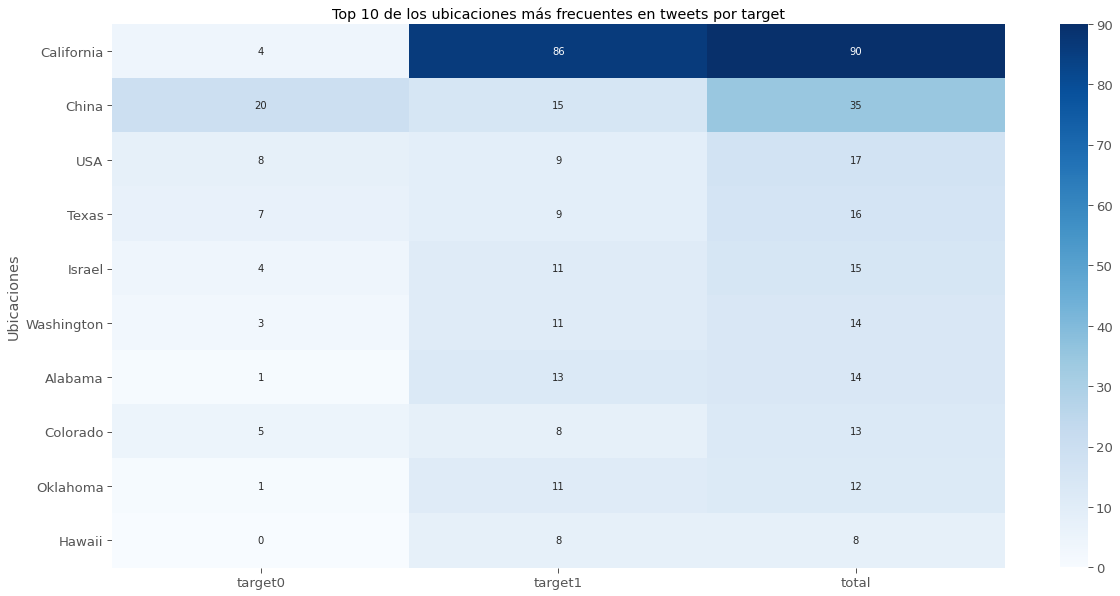

In [165]:
locs0=pd.DataFrame(top0,columns=['location','target0'])
locs1=pd.DataFrame(top1,columns=['location','target1'])

locs=locs0.merge(locs1, how='outer')
locs = locs.fillna(0)
locs['total']=locs['target0']+locs['target1']


aux_uni=(locs.sort_values(by='total', ascending=False))
aux_uni.set_index('location',inplace=True)

fig, ax = plt.subplots(figsize=(20,10))

heat_map = sns.heatmap(aux_uni.head(10),annot=True, fmt='g',cmap='Blues')
plt.yticks(rotation=0)
ax.set_title('Top 10 de los ubicaciones más frecuentes en tweets por target')
ax.set_ylabel('Ubicaciones')

plt.show()

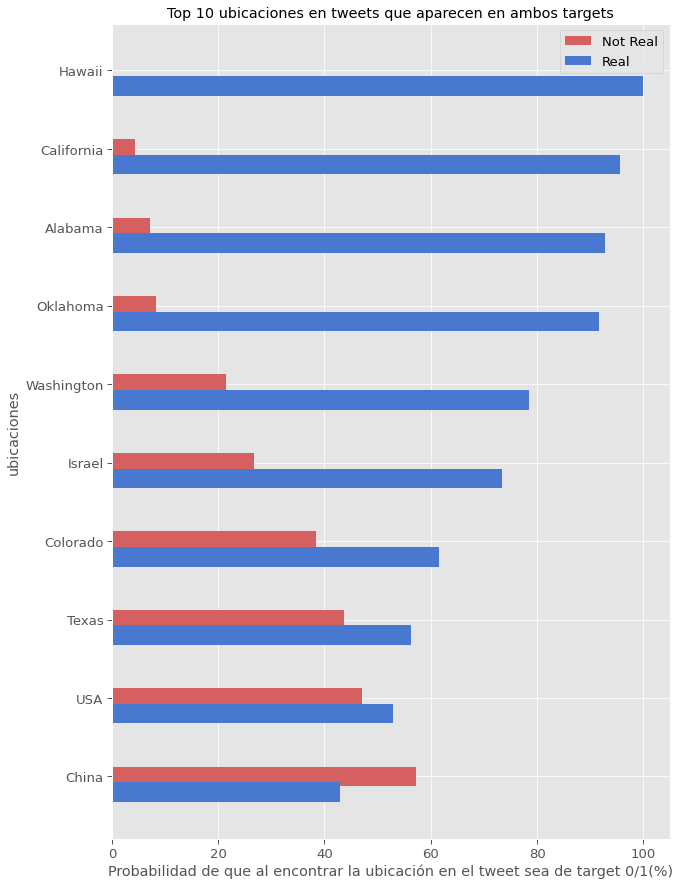

In [166]:

aux_uni['target0_norm']=100*aux_uni['target0']/(aux_uni['target0']+aux_uni['target1'])
aux_uni['target1_norm']=100*aux_uni['target1']/(aux_uni['target0']+aux_uni['target1'])
aux_uni=aux_uni.head(10)
aux_uni.sort_values(by='target0_norm',ascending=False,inplace=True)
aux_uni.reset_index(inplace=True)
aux_uni


fig, ax = plt.subplots(figsize=(10,15)) 
width=0.25
ax.barh(aux_uni.index,aux_uni['target0_norm'],width,color='r',label='Not Real')
ax.barh(aux_uni.index-0.2,aux_uni['target1_norm'],width,color = 'b',label='Real')
plt.yticks(aux_uni.index, aux_uni['location'])
ax.set_title('Top 10 ubicaciones en tweets que aparecen en ambos targets')
ax.set_ylabel('ubicaciones')
ax.set_xlabel('Probabilidad de que al encontrar la ubicación en el tweet sea de target 0/1(%)')
ax.legend(ncol=1, loc="upper right", frameon=True)
plt.show()
